# Introduction

Check the performance of a set of experiments the DCC says is ready for release

In [1]:
import pandas
import sys
import os
import base64
from io import BytesIO
from matplotlib import pyplot
from pathlib import Path
from IPython.display import HTML

In [2]:
%matplotlib agg

In [3]:
EC = str(Path("~/proj/encoded_client").expanduser())
if EC not in sys.path:
    sys.path.append(EC)

In [4]:
from encoded_client.encoded import ENCODED, get_object_type

In [5]:
server = ENCODED("www.encodeproject.org")
server.load_netrc()

In [6]:
#search = "https://www.encodeproject.org/search/?type=Experiment&@id=%2Fexperiments%2FENCSR479MNN%2F&@id=%2Fexperiments%2FENCSR288RRZ%2F&@id=%2Fexperiments%2FENCSR899OKE%2F&@id=%2Fexperiments%2FENCSR464VSR%2F&@id=%2Fexperiments%2FENCSR774MGO%2F&@id=%2Fexperiments%2FENCSR129VBC%2F&@id=%2Fexperiments%2FENCSR420YFF%2F&@id=%2Fexperiments%2FENCSR942YMN%2F&@id=%2Fexperiments%2FENCSR648YUM%2F&@id=%2Fexperiments%2FENCSR903XMI%2F&@id=%2Fexperiments%2FENCSR244HHV%2F&@id=%2Fexperiments%2FENCSR168PXI%2F&@id=%2Fexperiments%2FENCSR308XAR%2F&@id=%2Fexperiments%2FENCSR484WZL%2F"
search = "https://www.encodeproject.org/search/?type=Experiment&lab.title=Barbara+Wold%2C+Caltech&lab.title=Ali+Mortazavi%2C+UCI&lab.title=Rob+Spitale%2C+UCI&status=submitted&audit.WARNING.category!=lacking+processed+data&assay_title=total+RNA-seq"


In [7]:
graph = server.get_json(search)

In [8]:
experiment = server.get_experiment("/experiments/ENCSR288RRZ/")

New schema version 34


In [9]:
def format_alias(alias):
    return ",".join([x.split(':')[1] for x in alias])

def filter_gene_type_metric(metric):
    to_remove = [
        "@id", 
        "@type", 
        "aliases", 
        "assay_term_name",
        "assay_term_id",
        "attachment", 
        "date_created", 
        "quality_metric_of", 
        "schema_version",
        "status",
        "step_run",
        "submitted_by",
        "lab", 
        "award", 
        "uuid"
    ]
    filtered_metric = metric.copy()
    for remove in to_remove:
        if remove in filtered_metric:
            del filtered_metric[remove]
        else:
            print("Warning {} not found".format(remove))
    return filtered_metric


def plot_gene_type_metric(gene_types):
    stream = BytesIO()
    f = pyplot.figure(figsize=(8,8))
    ax = f.add_subplot(1,1,1)
    gene_types.T.plot.bar(stacked=True, ax=ax)
    f.savefig(stream, format='png')
    return base64.b64encode(stream.getvalue()).decode('ascii')
   
    
def report_experiment(experiment):    
    star_quality = {}
    spearman = {}
    gene_types = {}
    for replicate in experiment.replicates:
        alias = format_alias(replicate["library"]["aliases"])


        for file in replicate["files"]:
            for i, metric in enumerate(file["quality_metrics"]):
                metric_for = ",".join(file._json["quality_metrics"][i]["quality_metric_of"])
                if get_object_type(metric) == "StarQualityMetric":
                    mapped = metric['Number of reads mapped to multiple loci'] + metric['Uniquely mapped reads number']
                    fraction_mapped = mapped / metric['Number of input reads']                    
                    star_quality[(alias, file["output_type"])] = {
                        'multi': metric['Number of reads mapped to multiple loci'],
                        'uniq': metric['Uniquely mapped reads number'],
                        'mapped': mapped,
                        'total': metric['Number of input reads'],
                        '%mapped': "{:.4}".format(fraction_mapped * 100),
                    }
                    #print(alias, metric)
                elif get_object_type(metric) == "MadQualityMetric":
                    spearman[metric_for] = metric
                    spearman[metric_for].setdefault('alias', set()).add(alias)
                elif get_object_type(metric) == "GeneTypeQuantificationQualityMetric":
                    gene_types[alias] = filter_gene_type_metric(metric)

    #print(pandas.DataFrame(star_quality).T)
    #plot_gene_type_metric(pandas.DataFrame(gene_types))
    block = [
        '<h1><a href="https://www.encodeproject.org{}">{}</a> {}</h1>'.format(experiment['@id'], experiment['accession'], experiment['description'])
    ]
    if len(star_quality) > 0:
        star_quality = pandas.DataFrame(star_quality).T
        block.append(star_quality.to_html())
    if len(spearman) > 0:
        for metric_for, s in spearman.items():
            block.append("<p>Spearman: {} {}</p>".format(','.join(s['alias']), s["Spearman correlation"]))
    if len(gene_types) > 0:
        gene_types = pandas.DataFrame(gene_types)
        block.append('<p><img src="data:image/png;base64,{}"/></p>'.format(plot_gene_type_metric(gene_types)))
    return block


New schema version 34
New schema version 34
New schema version 34
New schema version 34
New schema version 34
New schema version 34
New schema version 34
New schema version 34
New schema version 34
New schema version 34
New schema version 34
New schema version 34
New schema version 34
New schema version 34
New schema version 34
New schema version 34
New schema version 34
New schema version 34
New schema version 34
New schema version 34
New schema version 34
<ipython-input-9-4834e32007f3>:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = pyplot.figure(figsize=(8,8))
New schema version 34
New schema version 34
New schema version 34
New schema version 34
New schema version 34
New schema version 34
New schema version 34
New schema version 34
New schema version 34
N


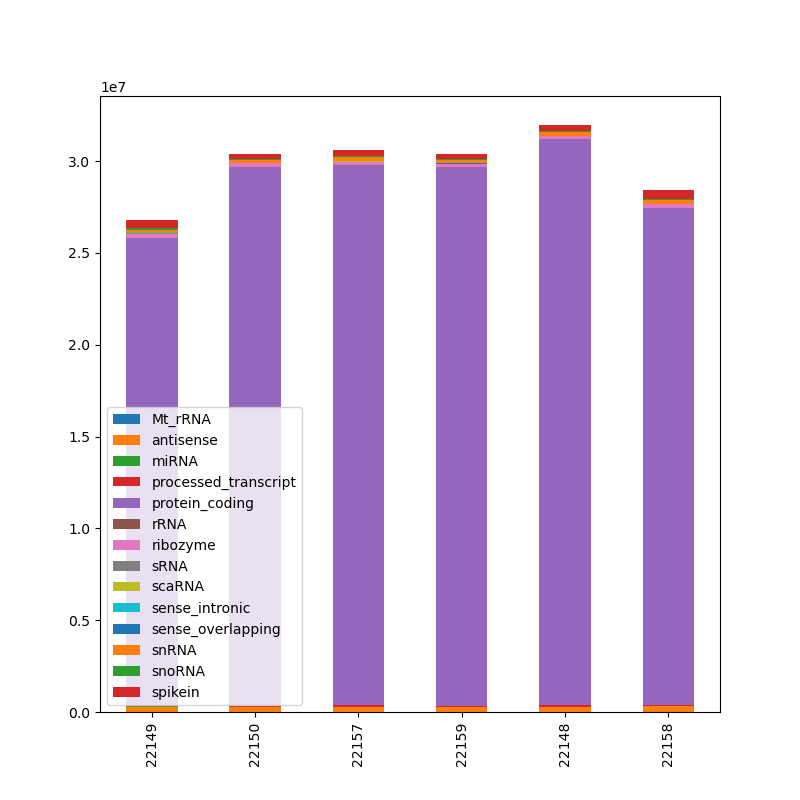
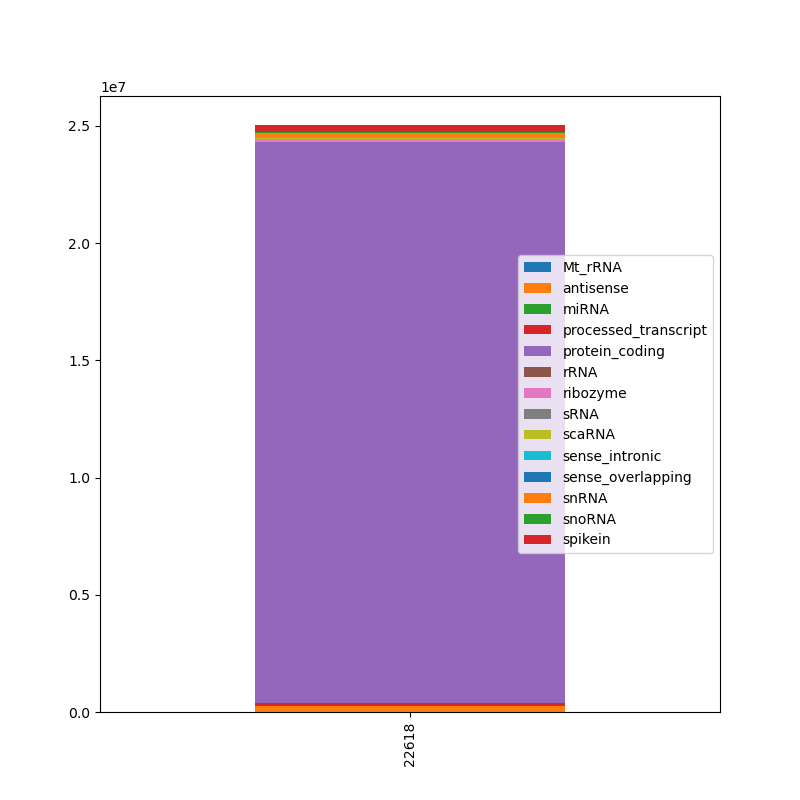
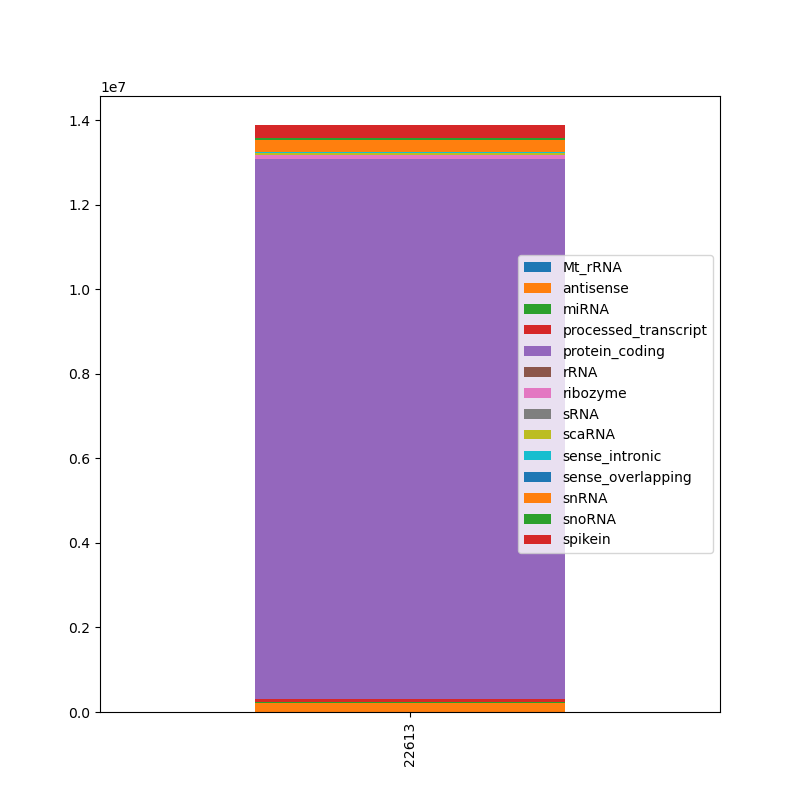
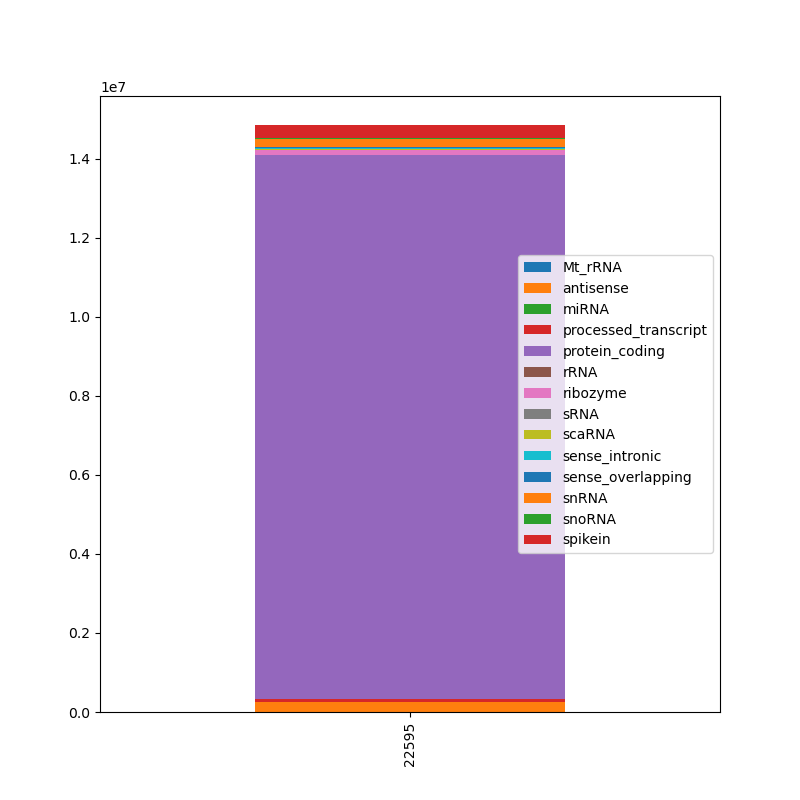
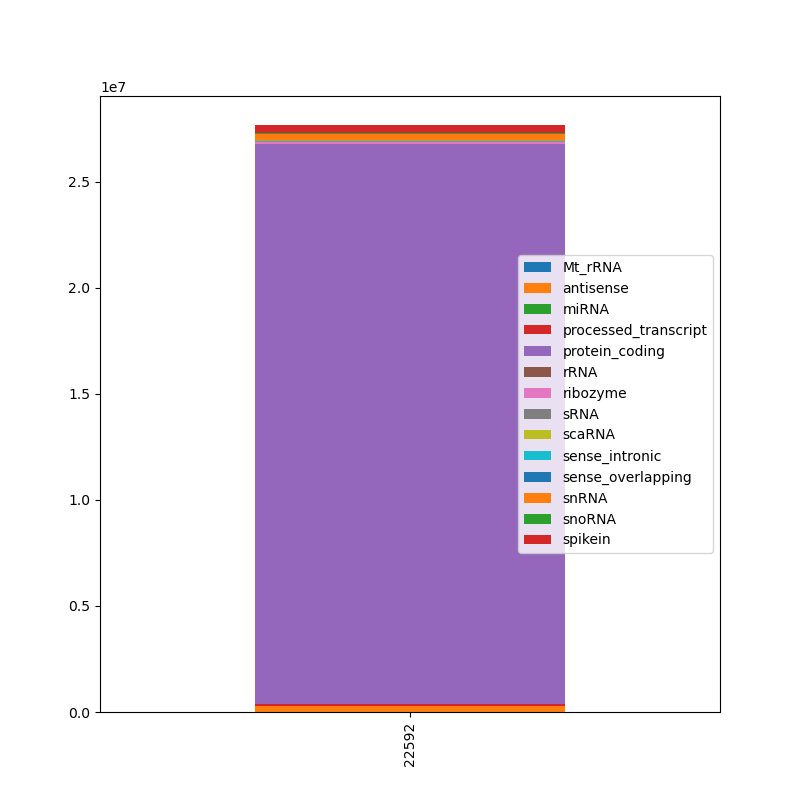
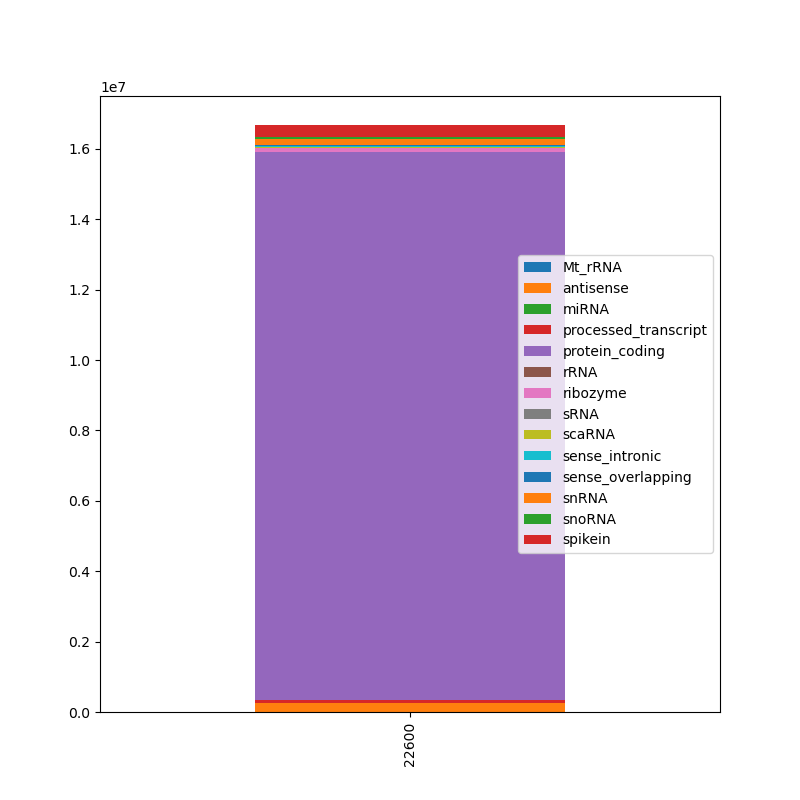
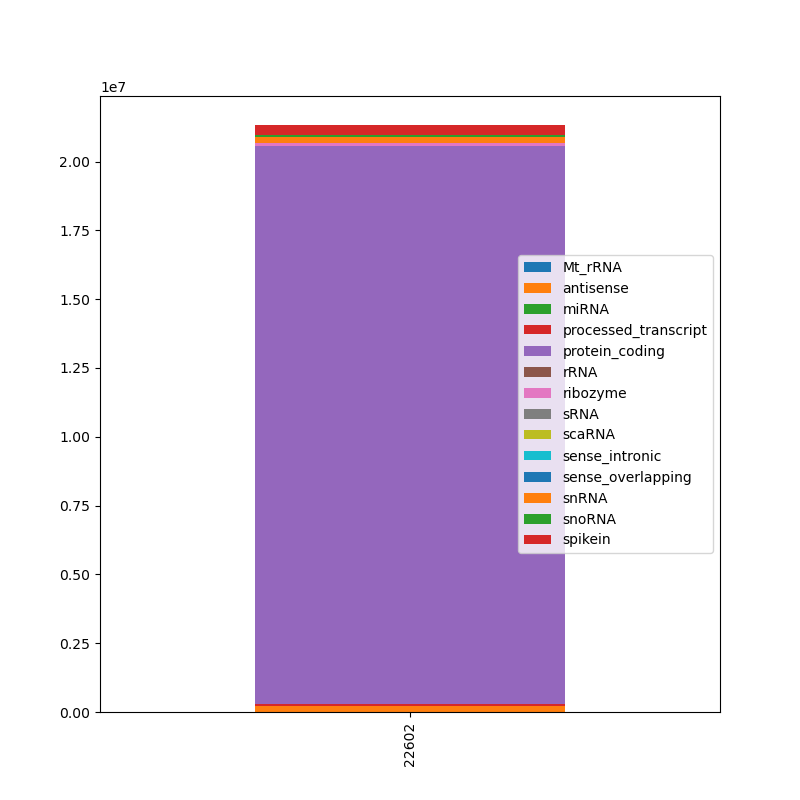
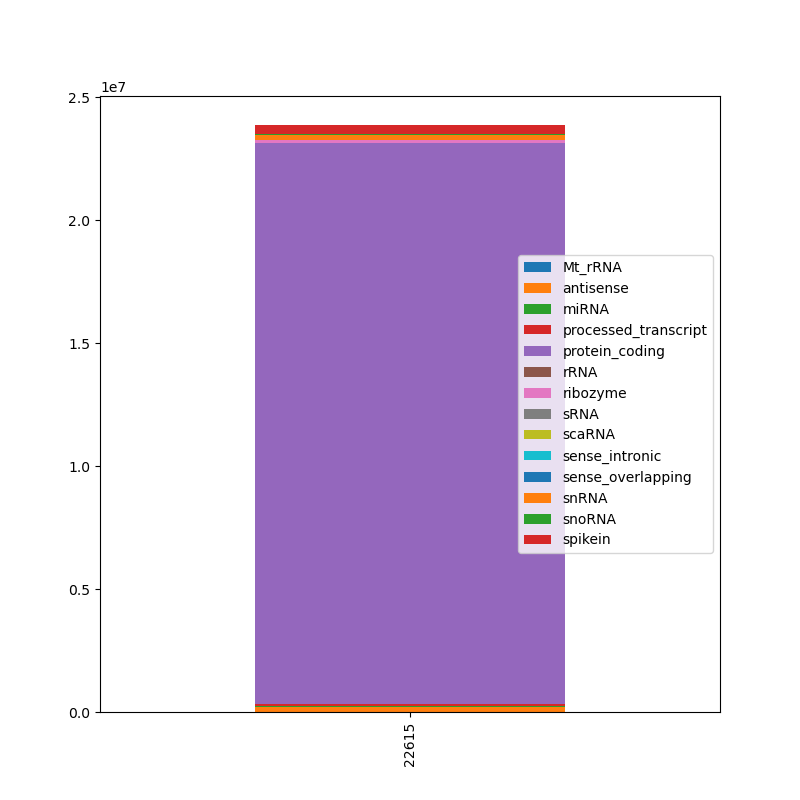
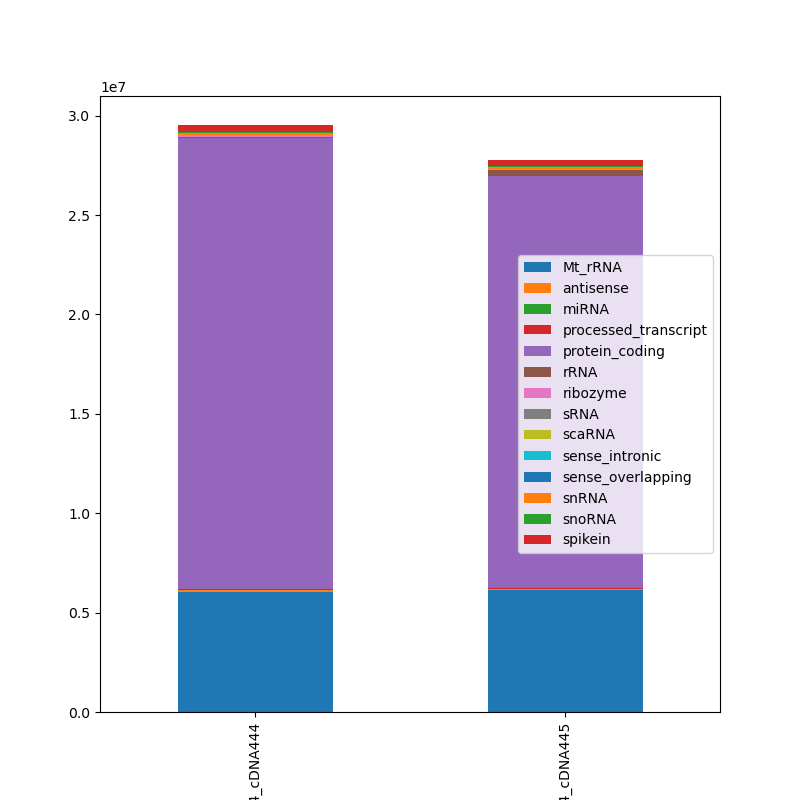
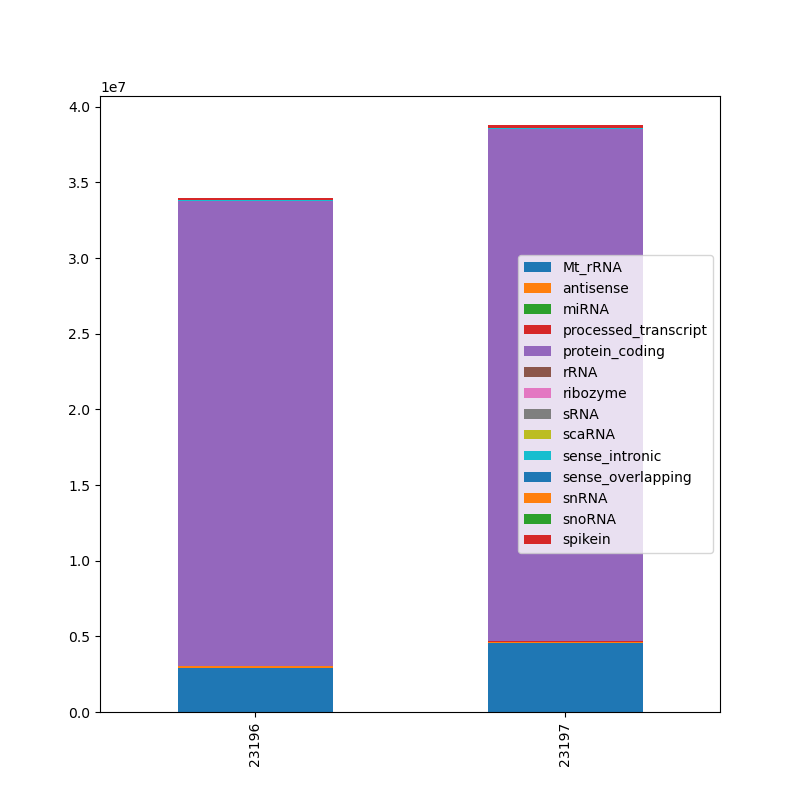
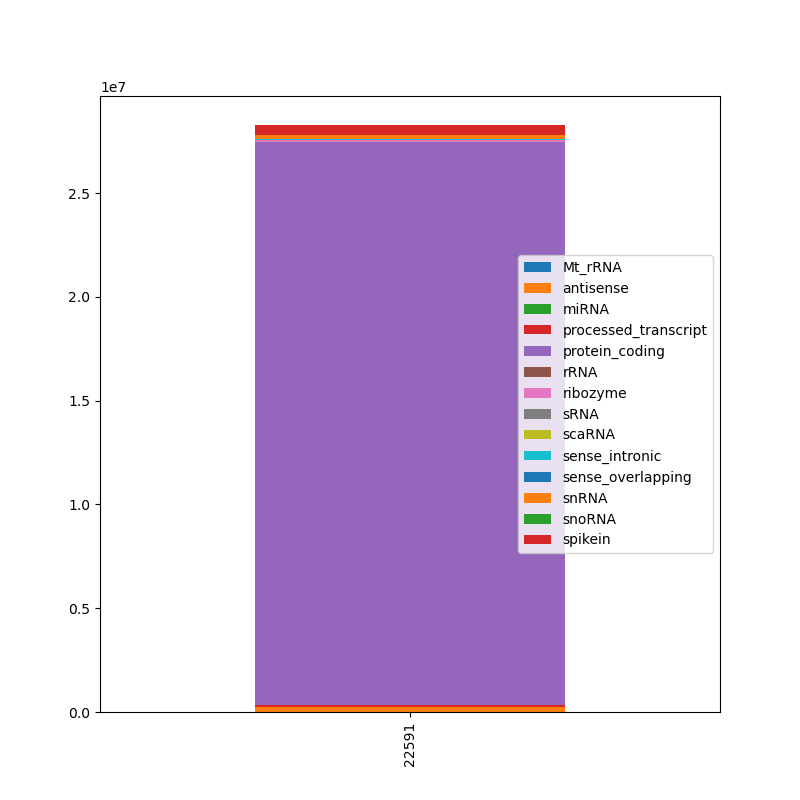
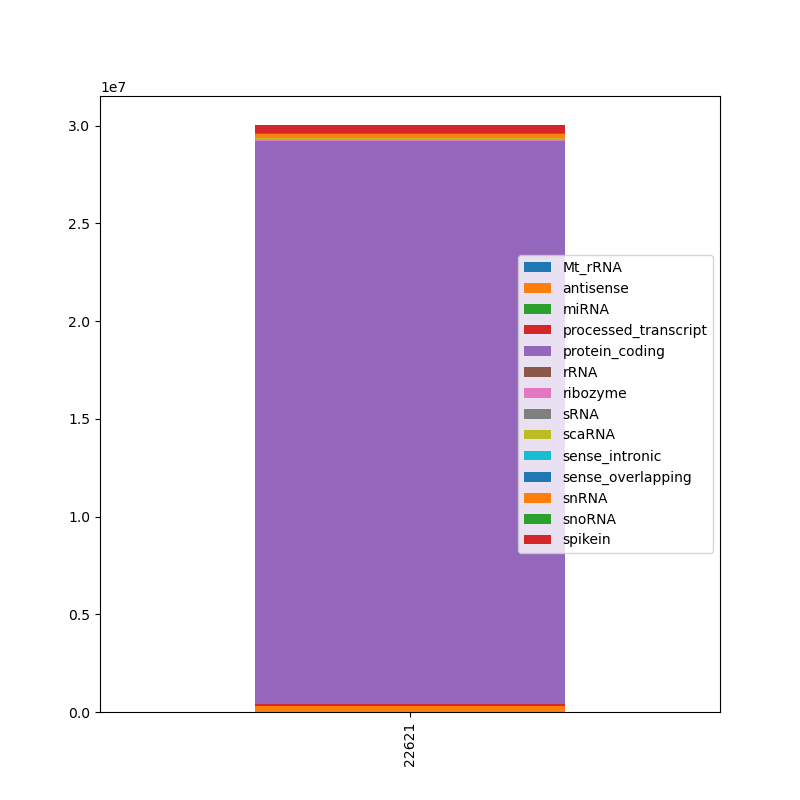
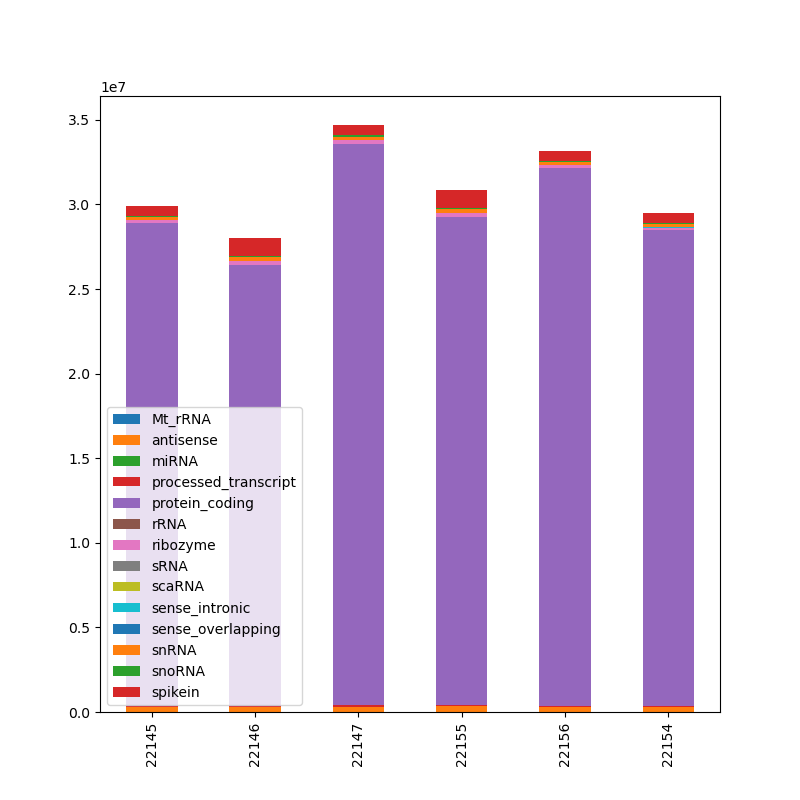
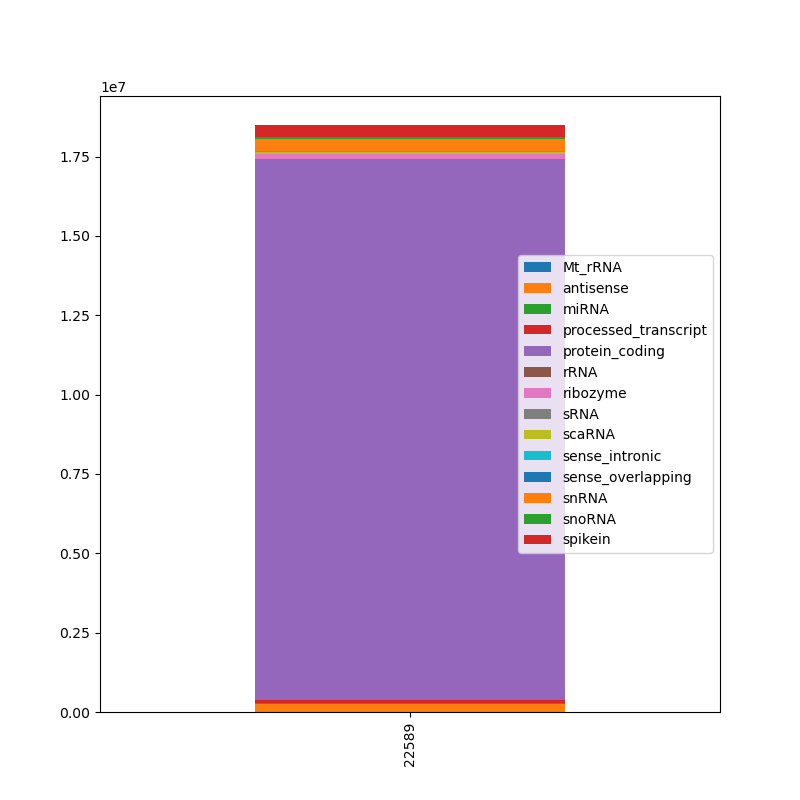
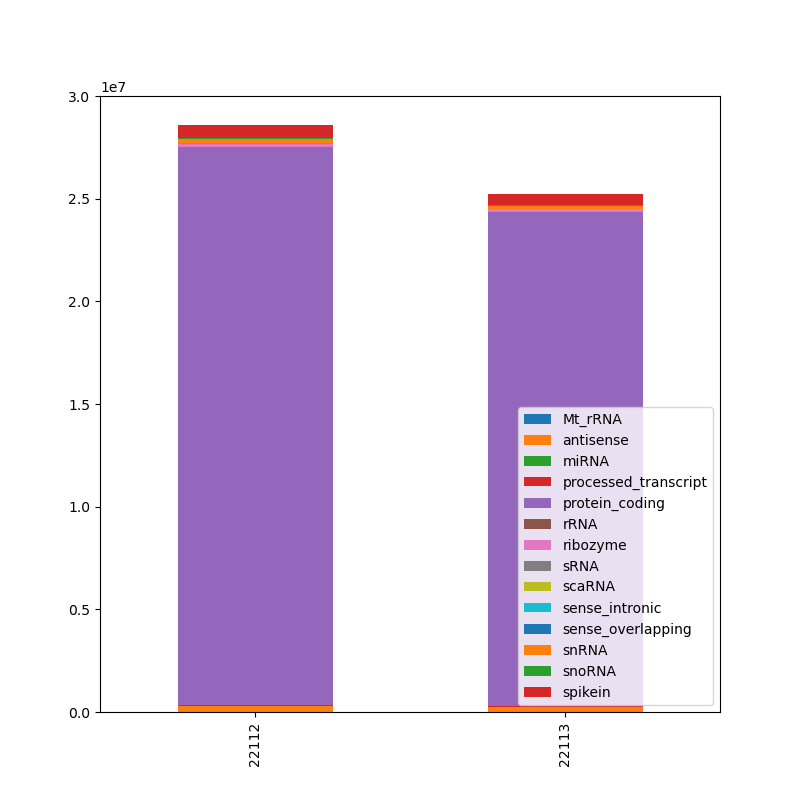
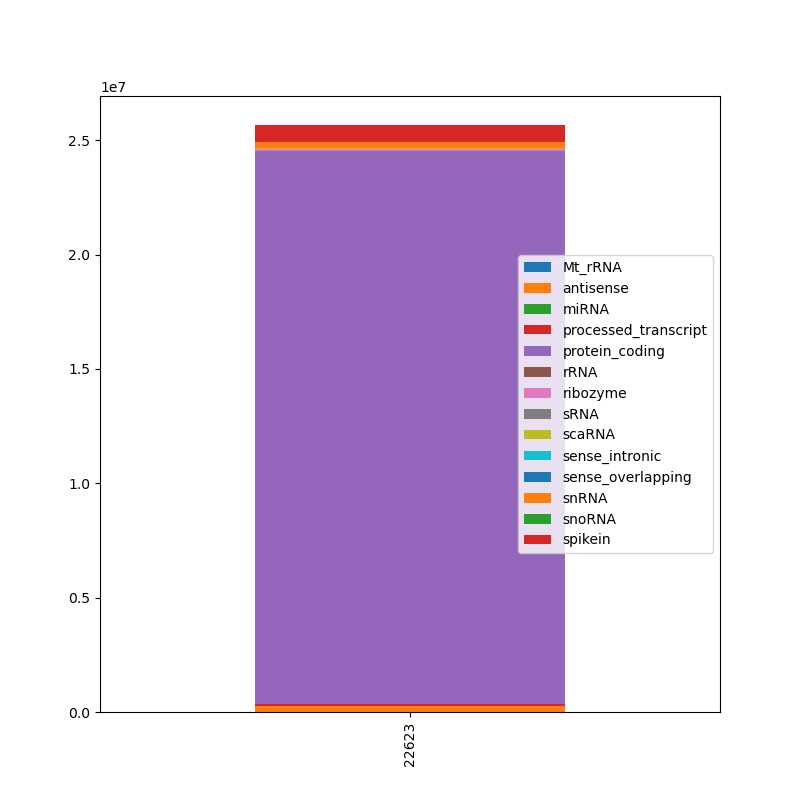
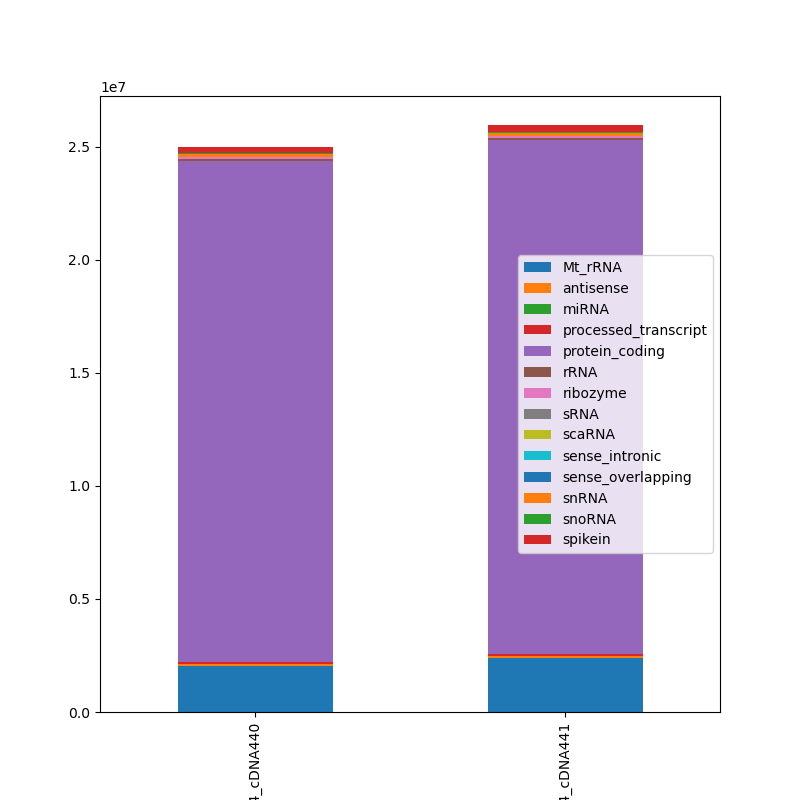
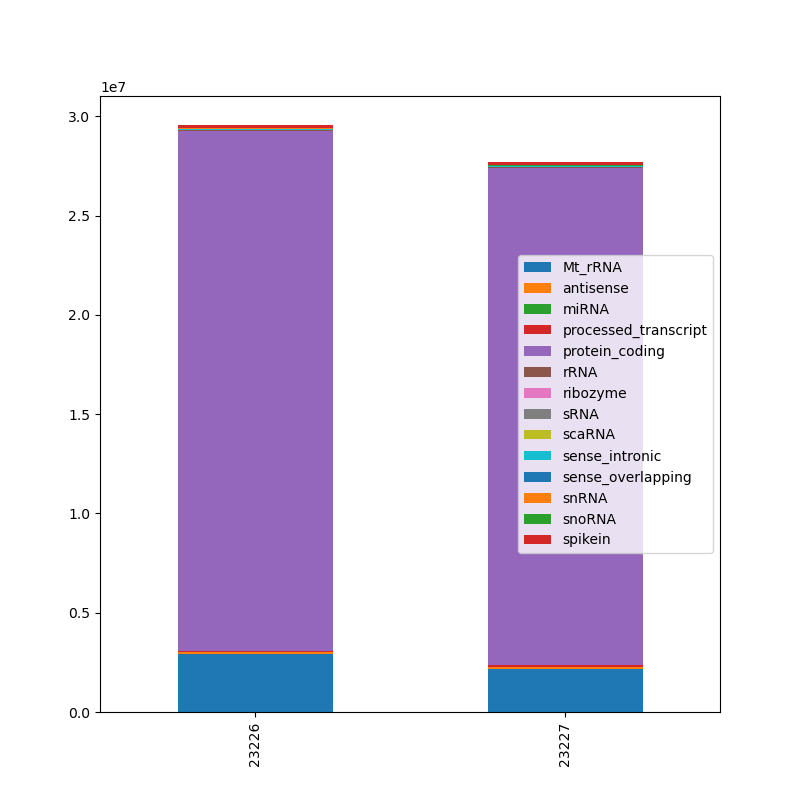
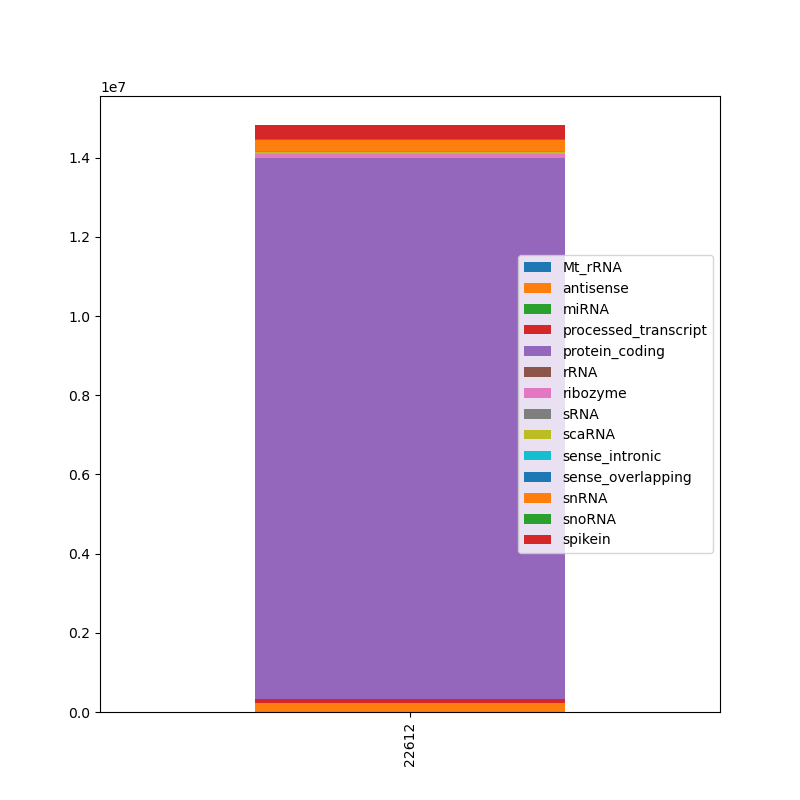
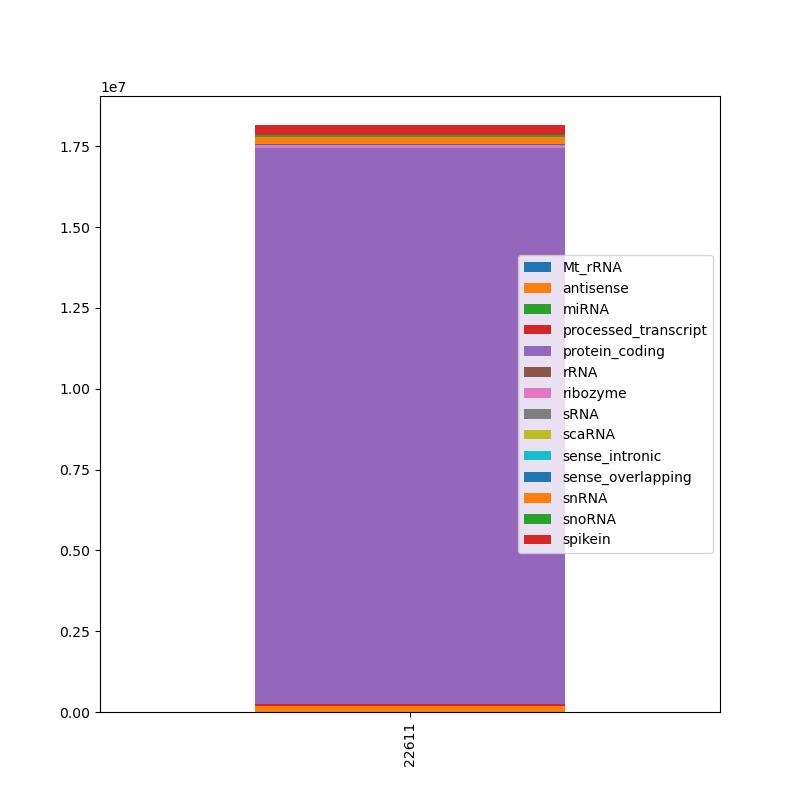
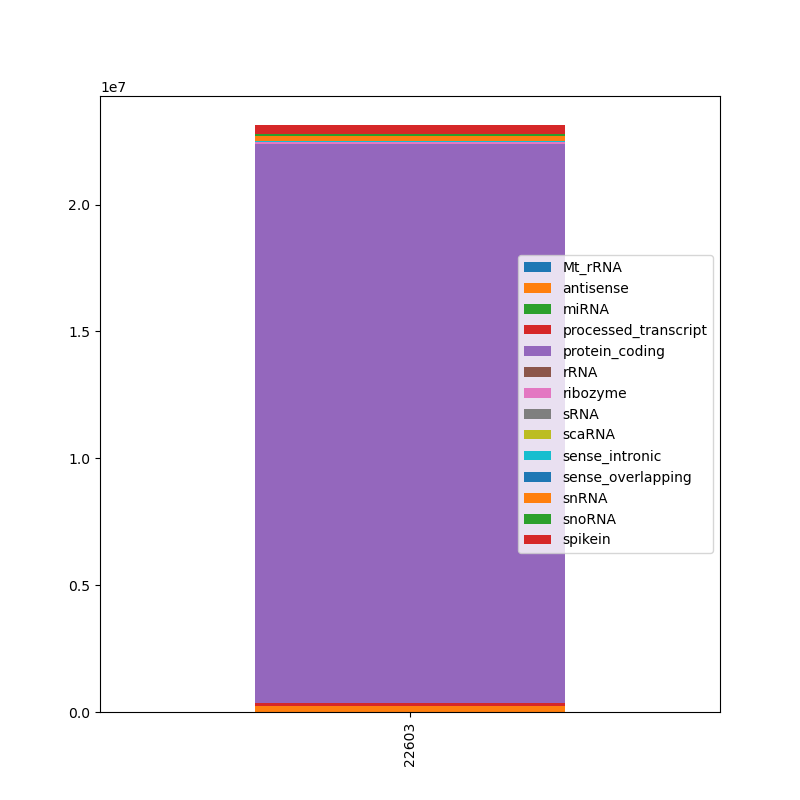
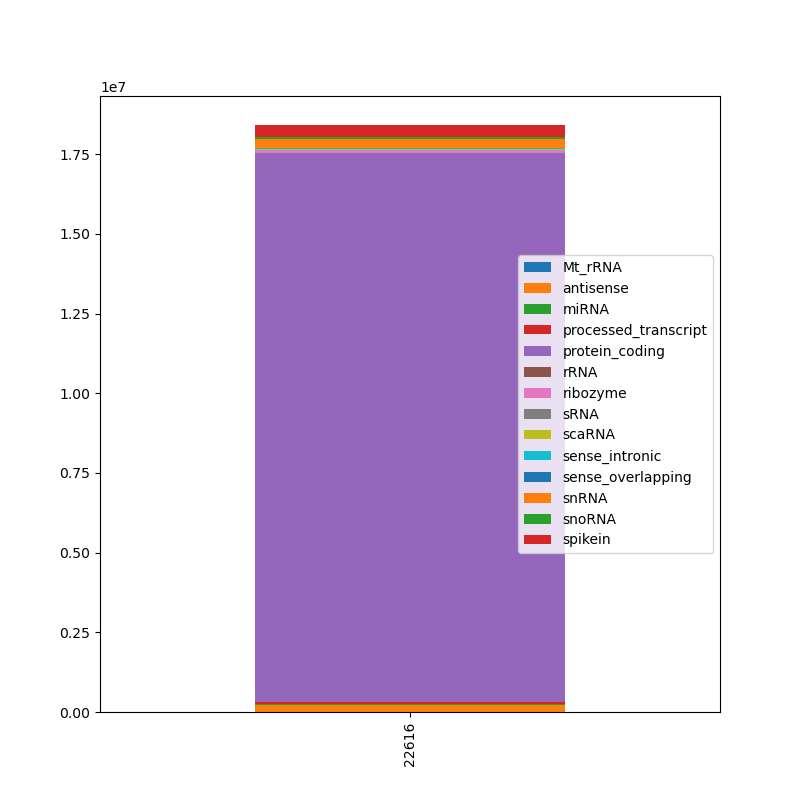
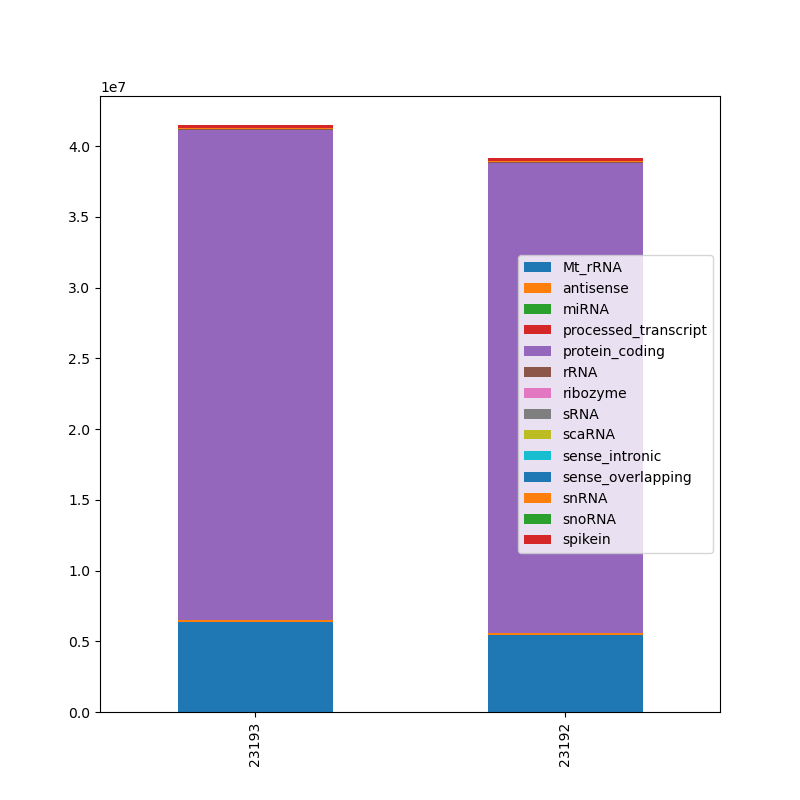
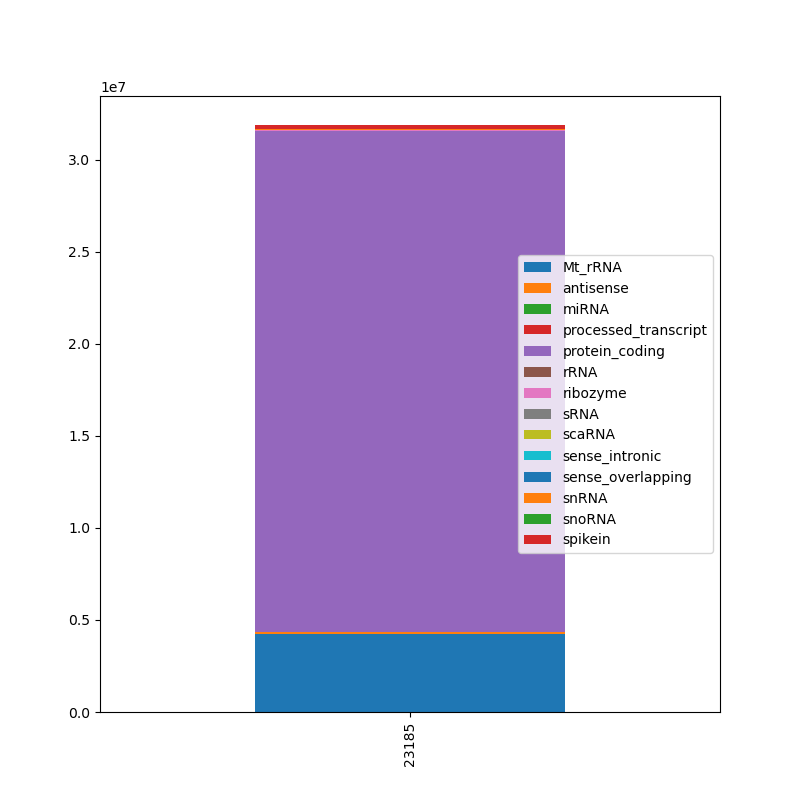
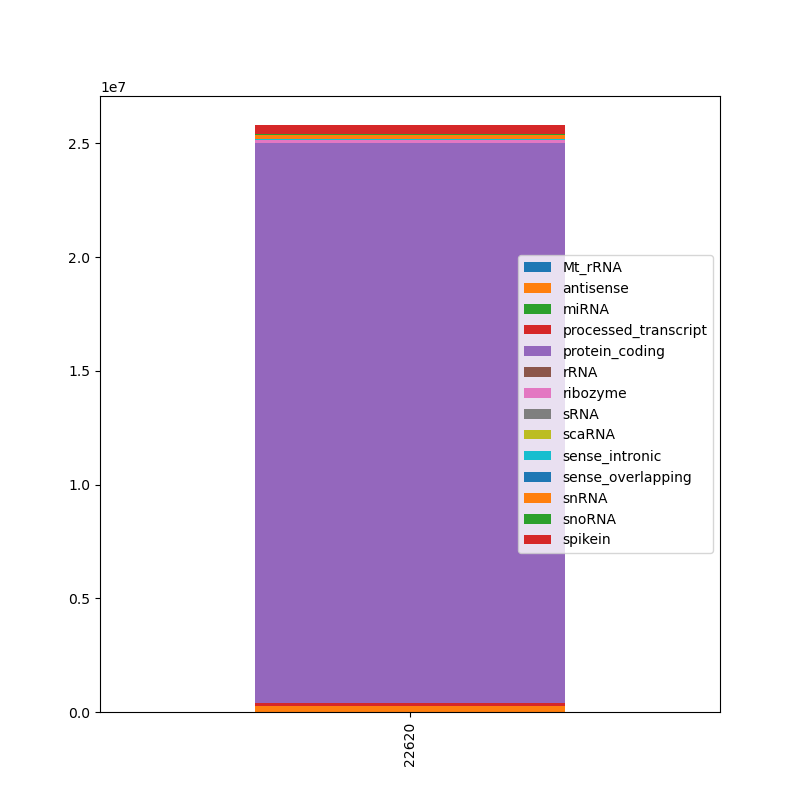
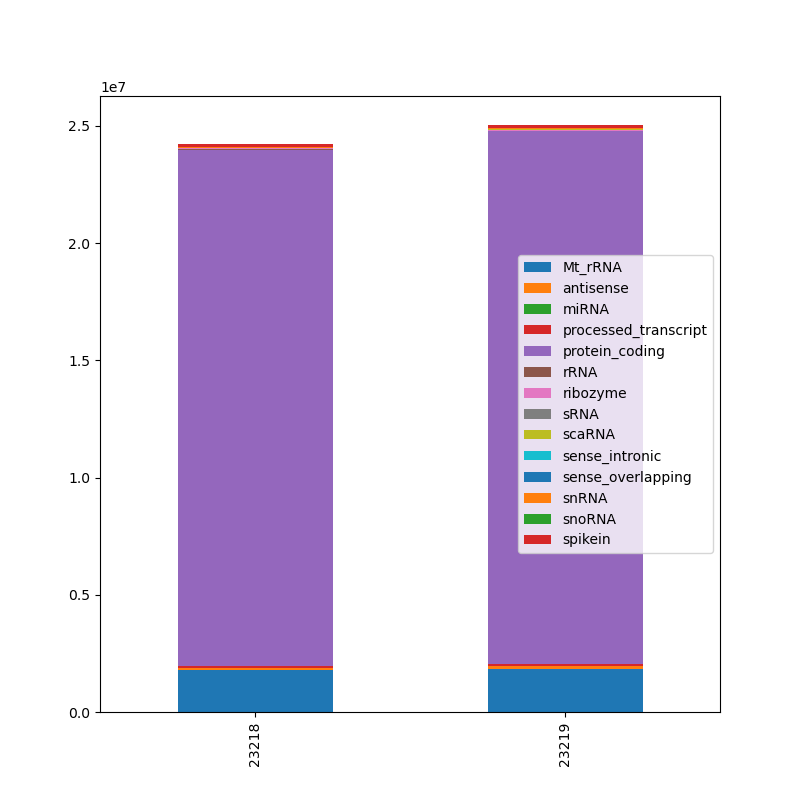
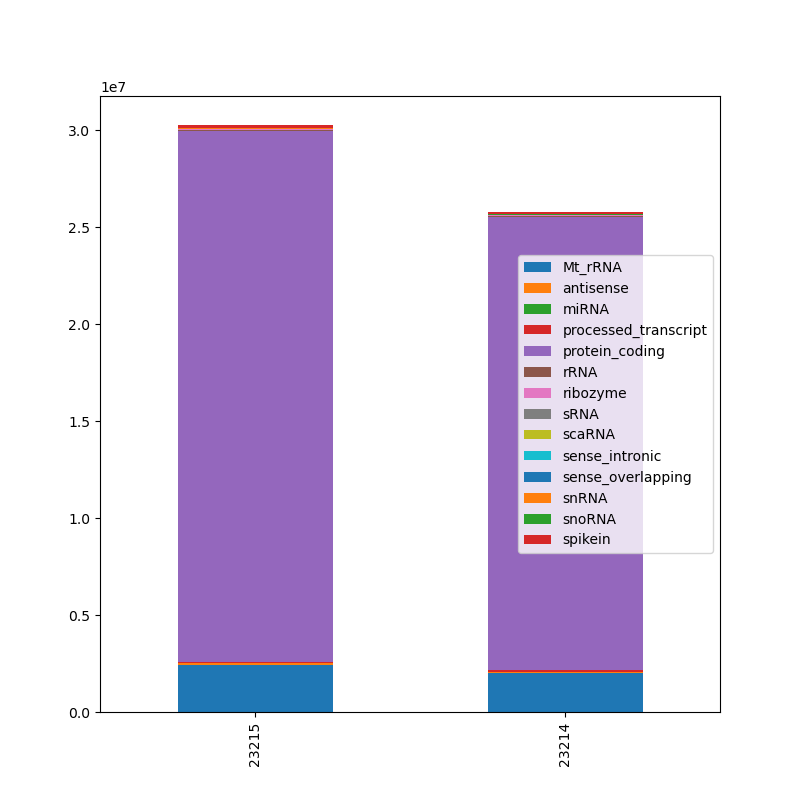
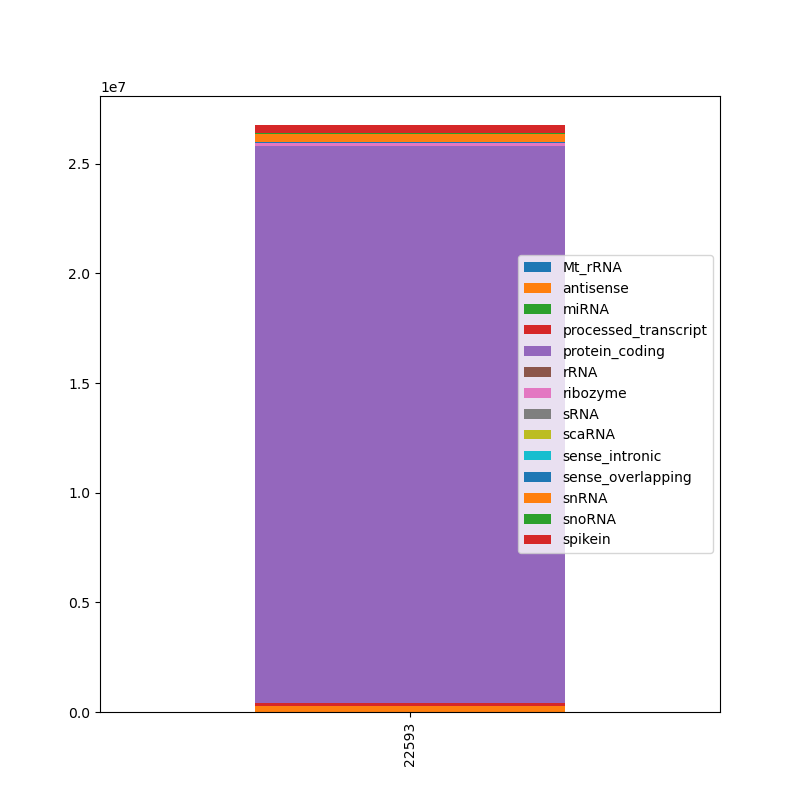
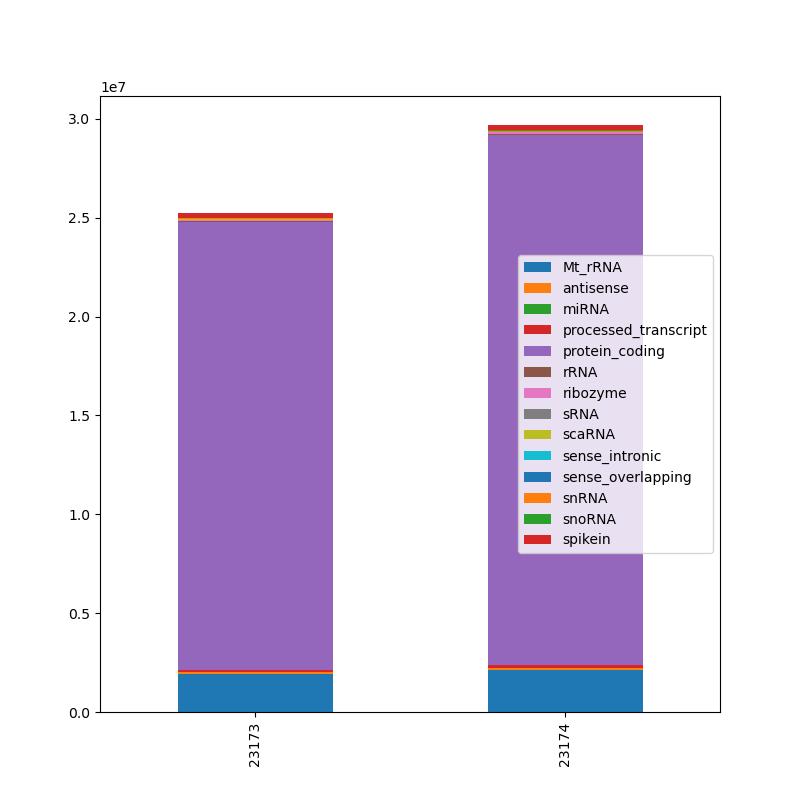
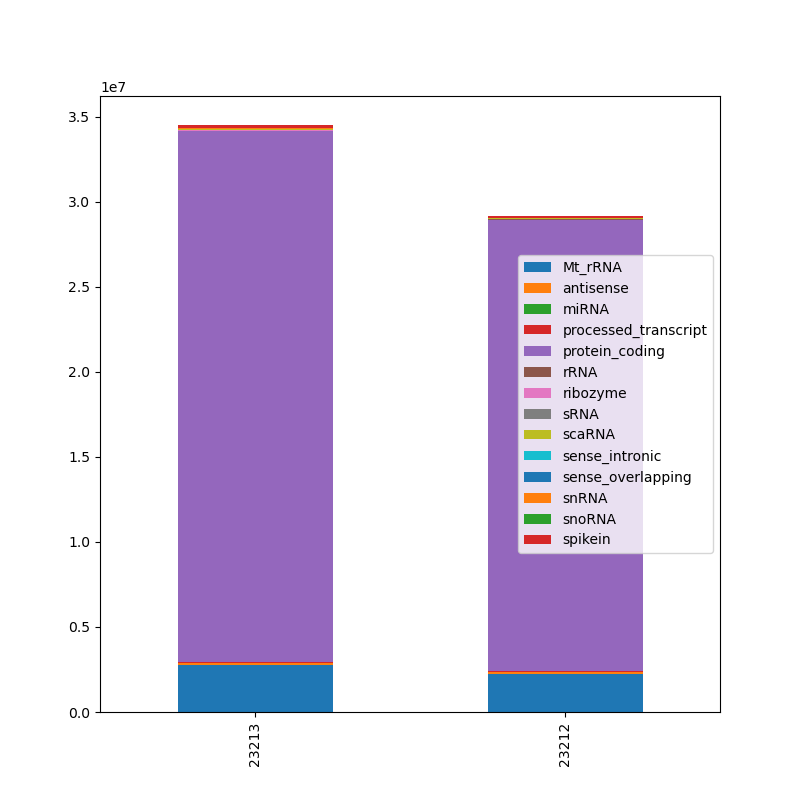
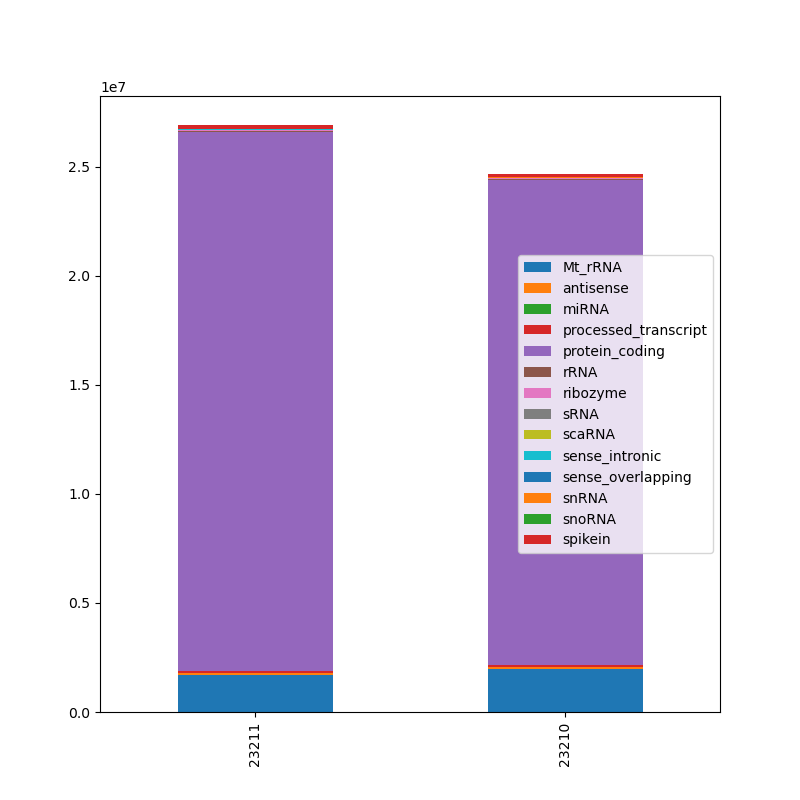
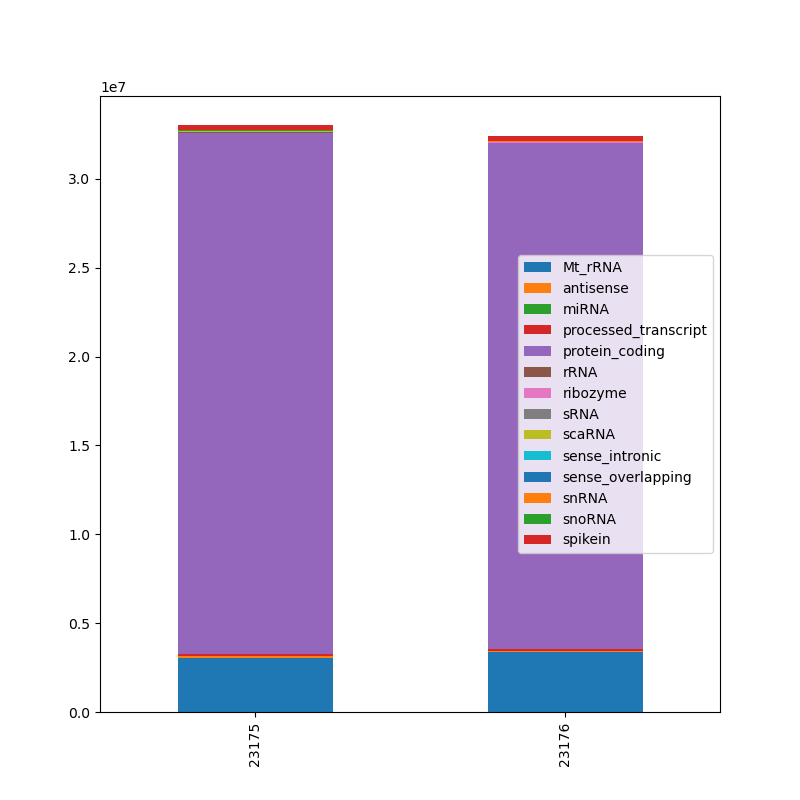
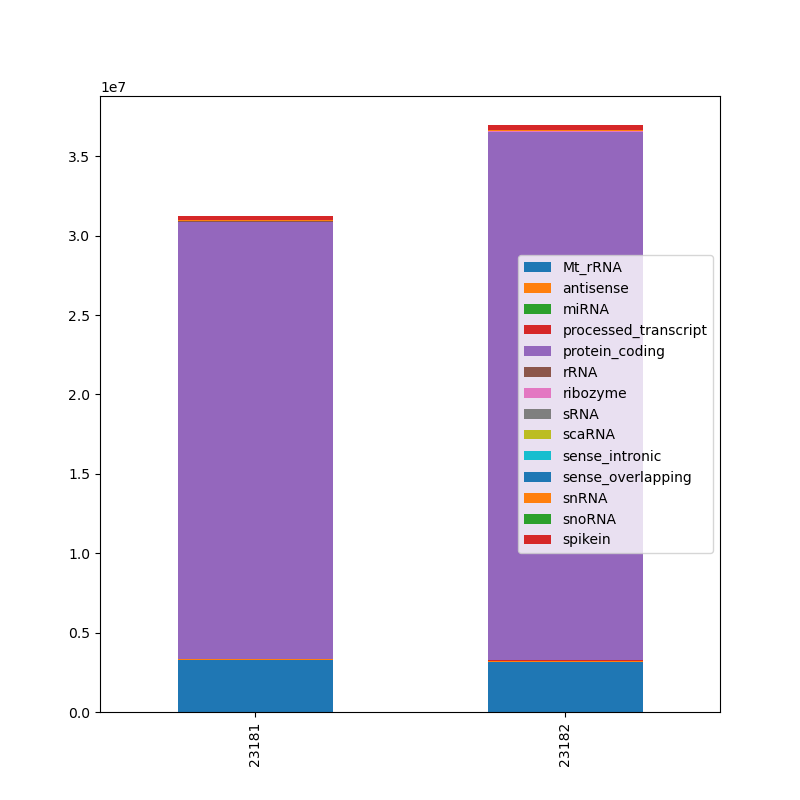
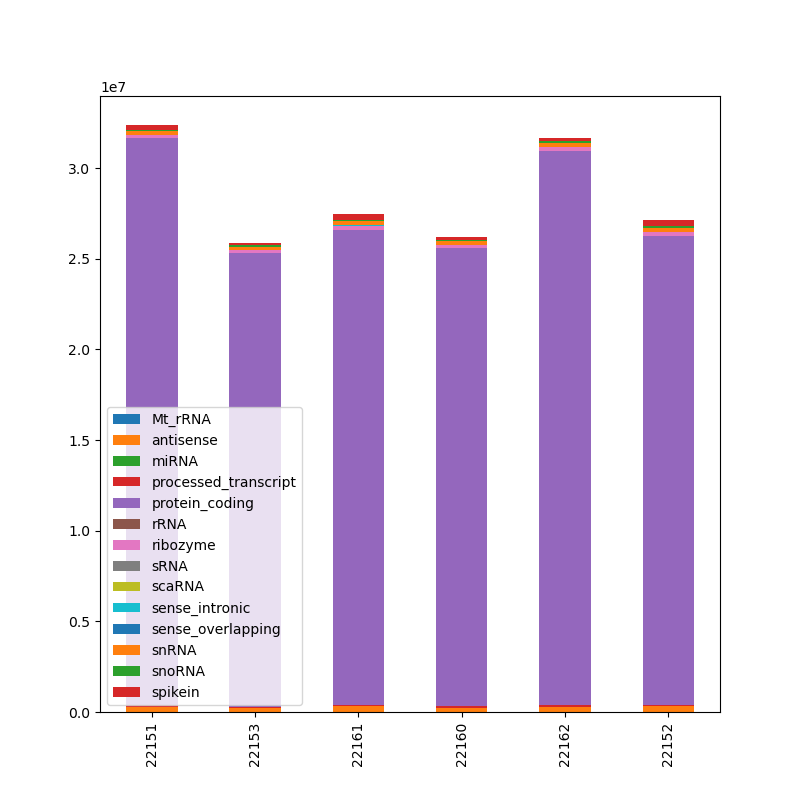
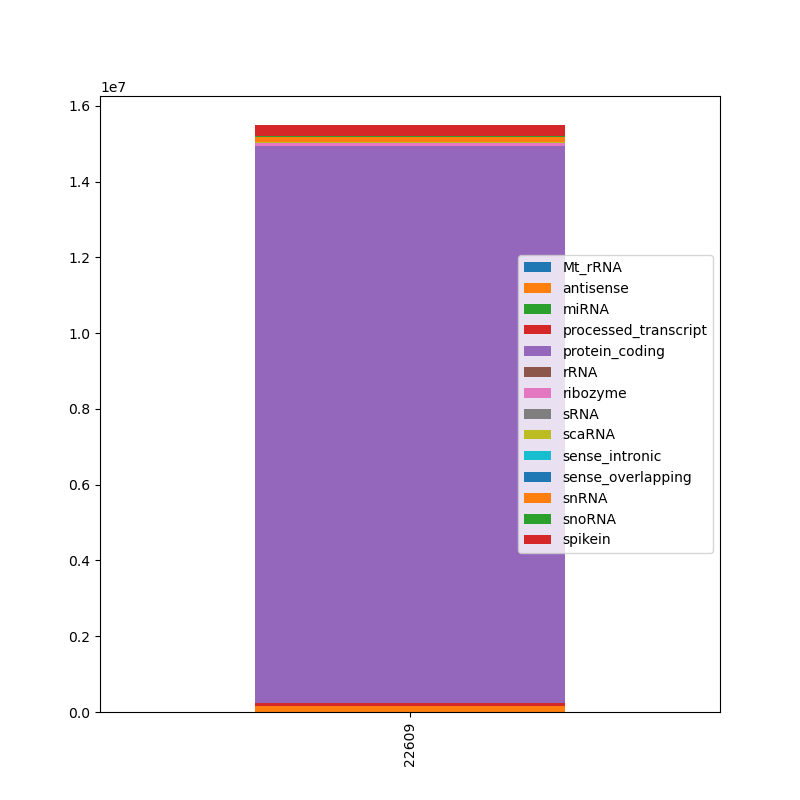
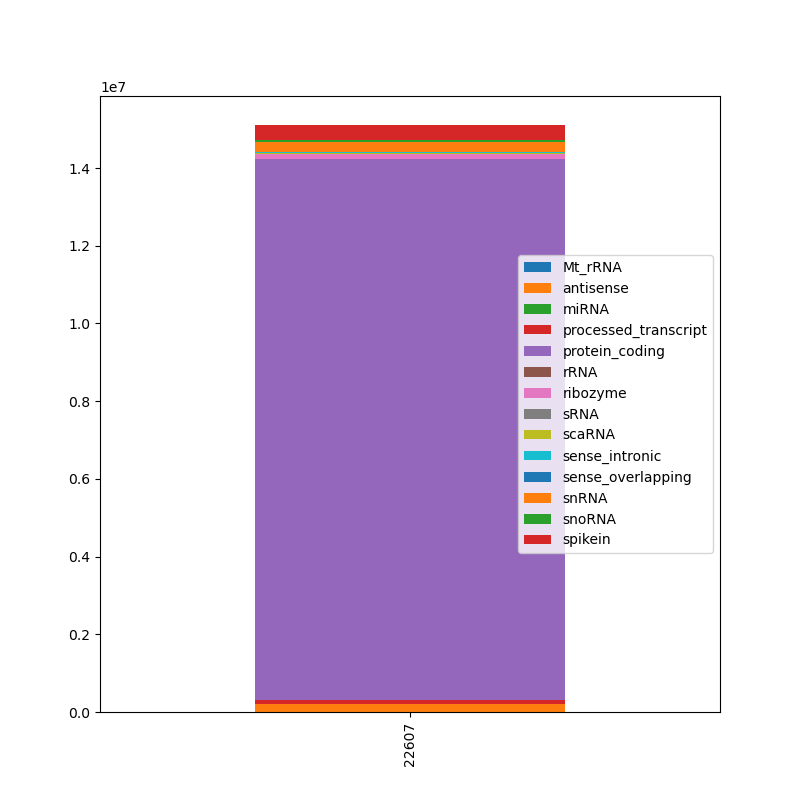
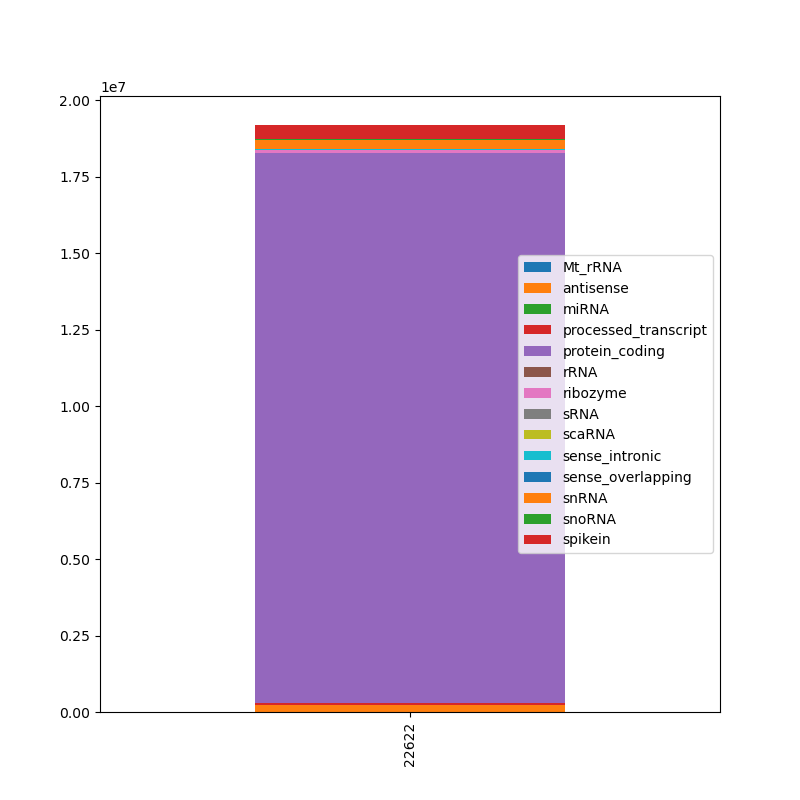
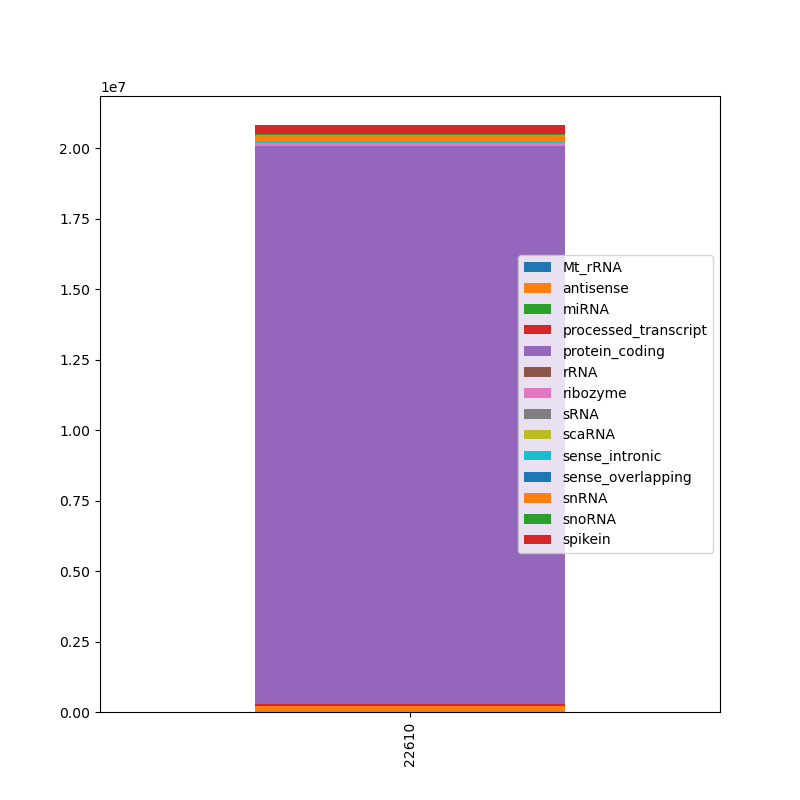
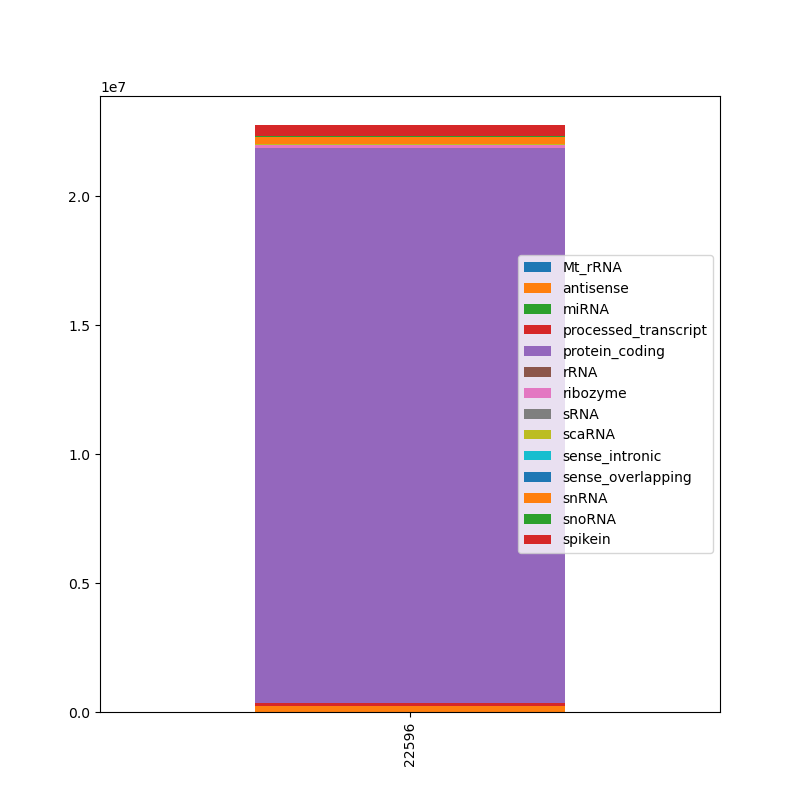
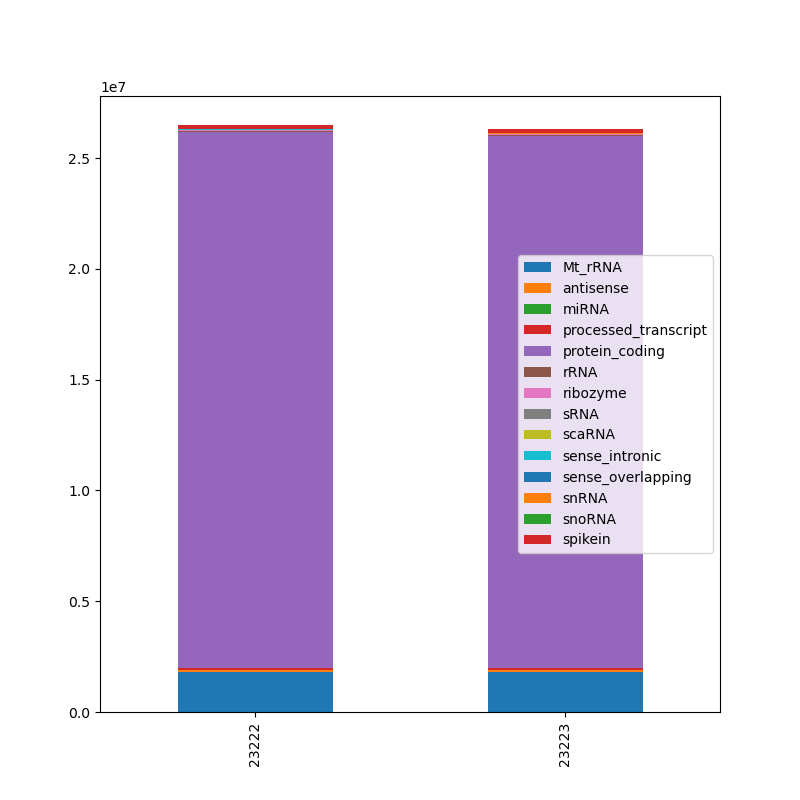
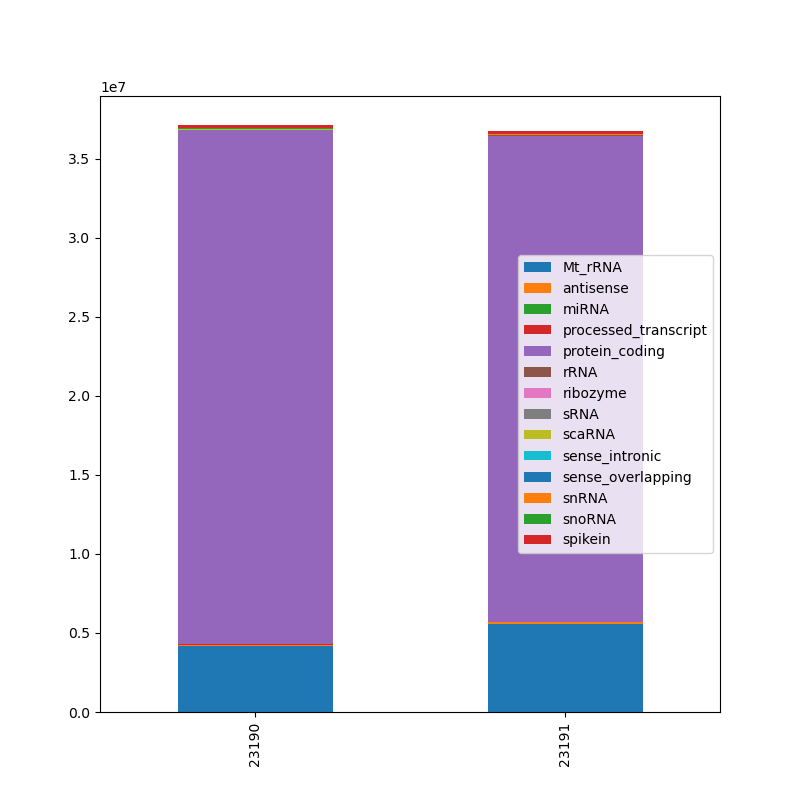
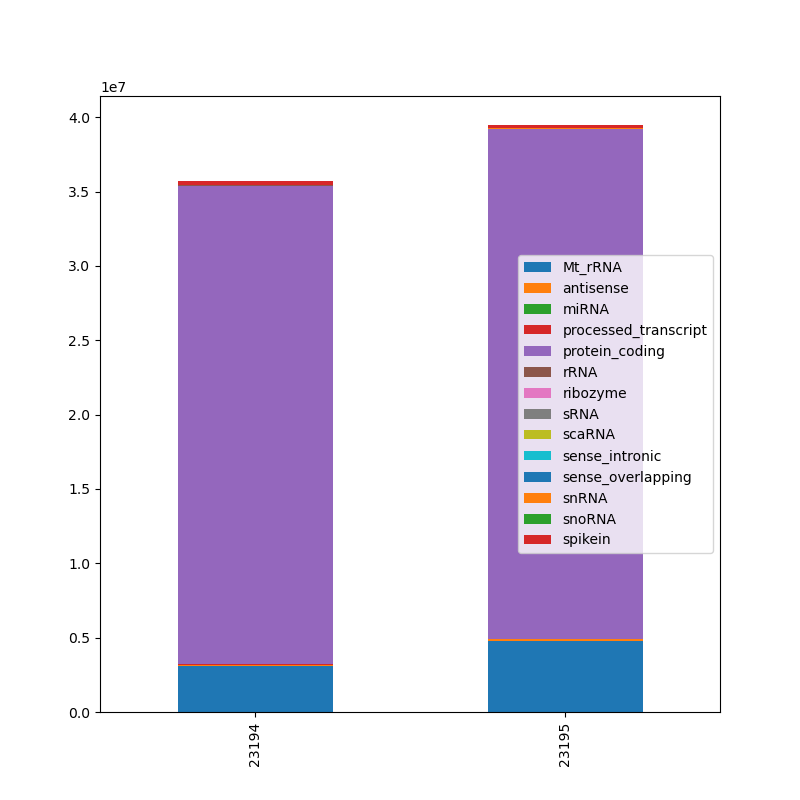
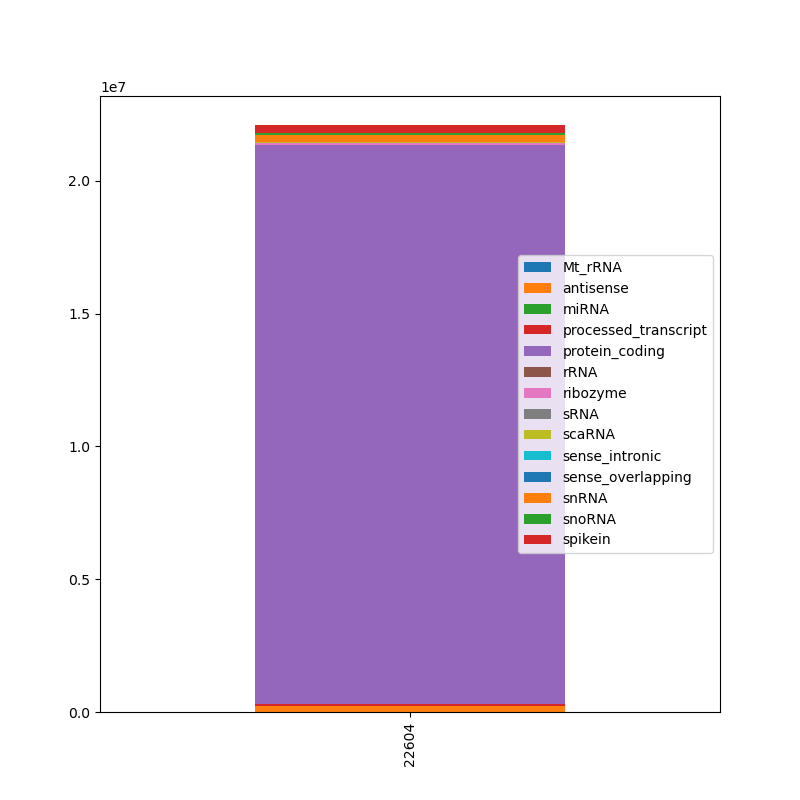
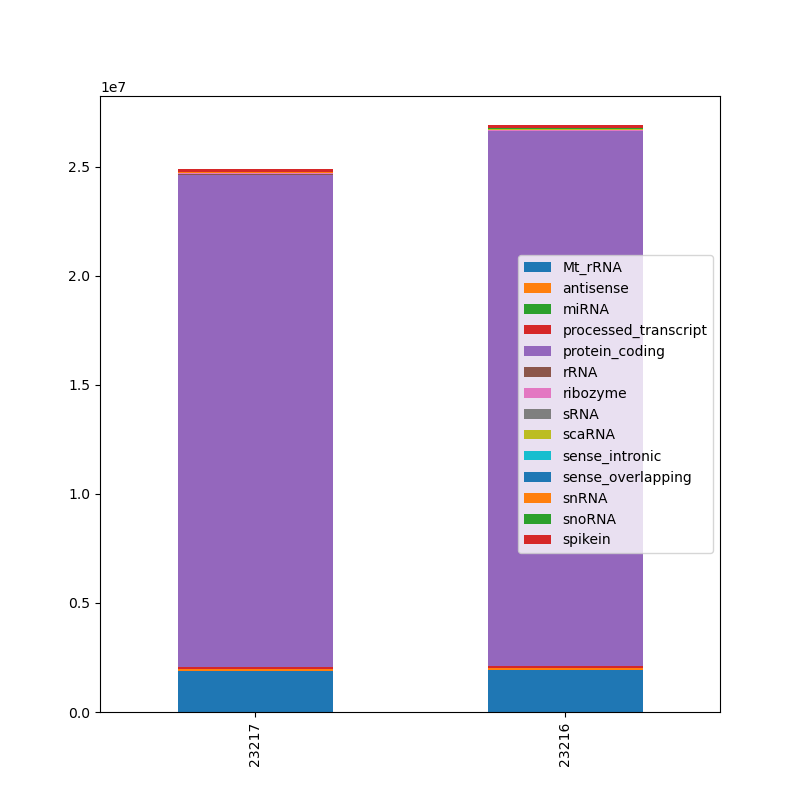
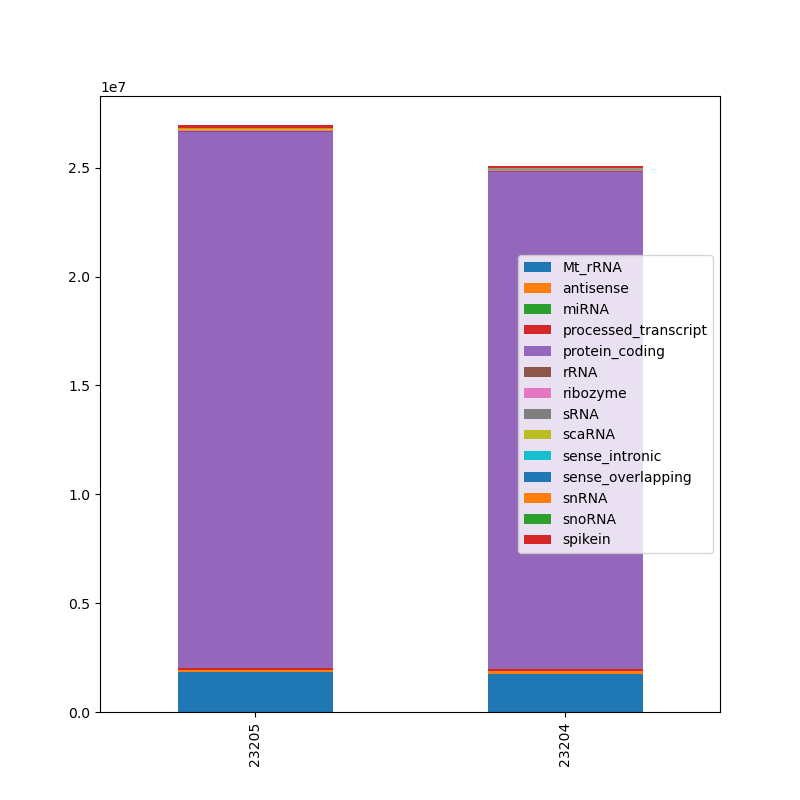
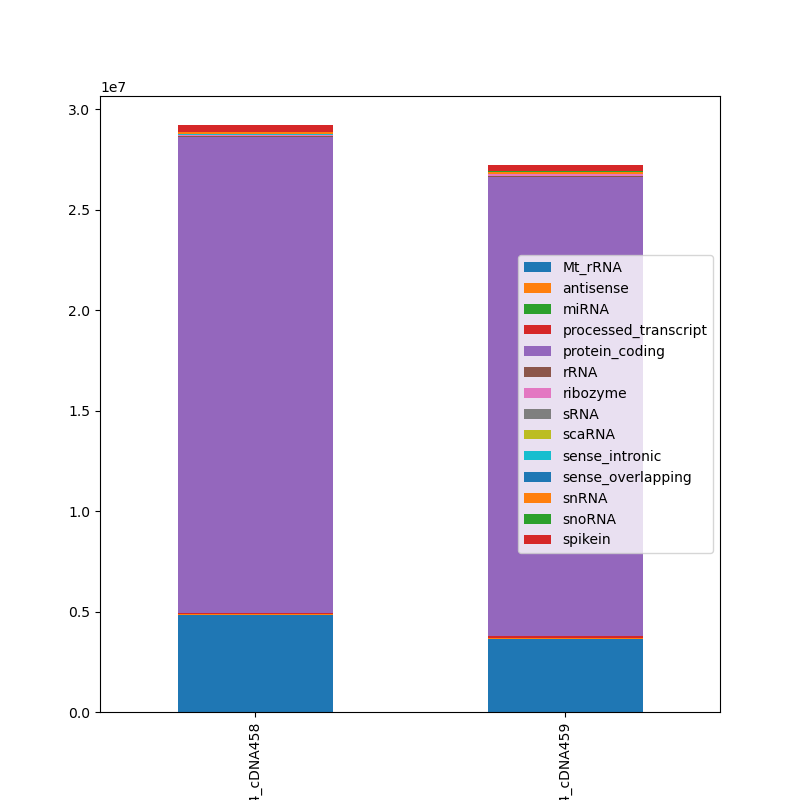
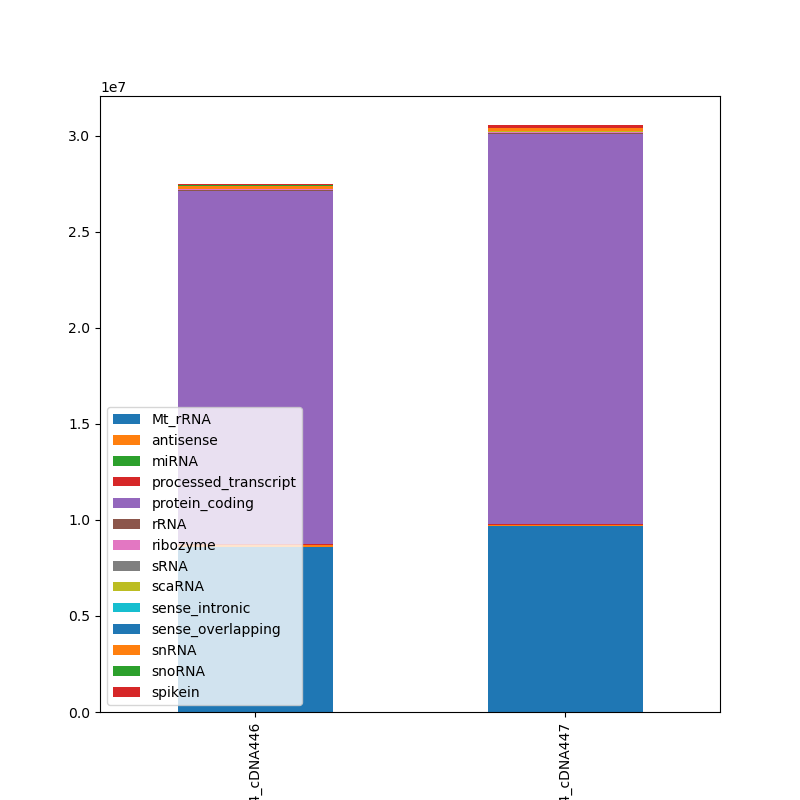
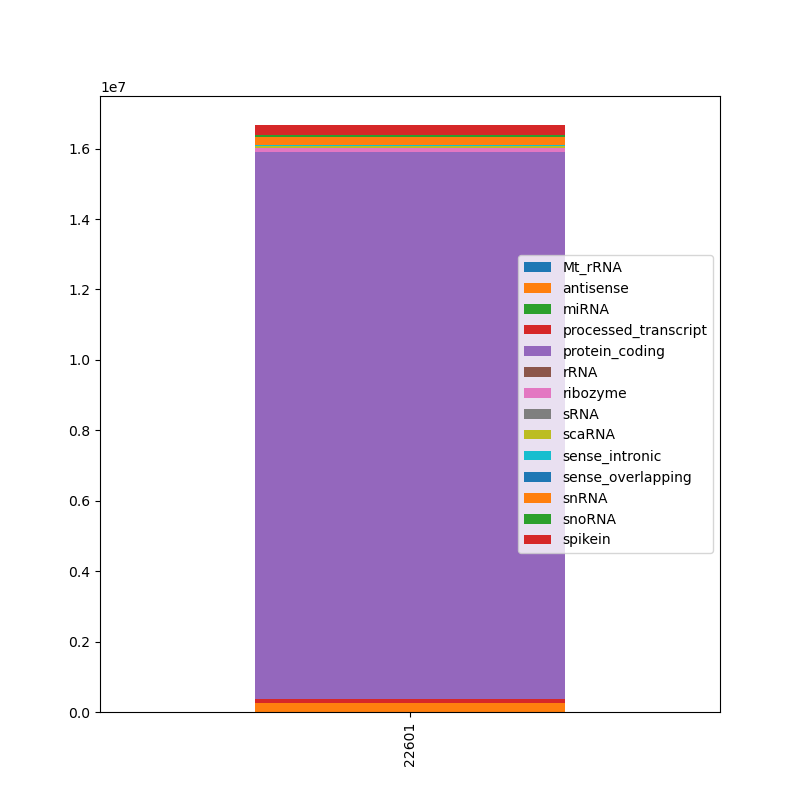
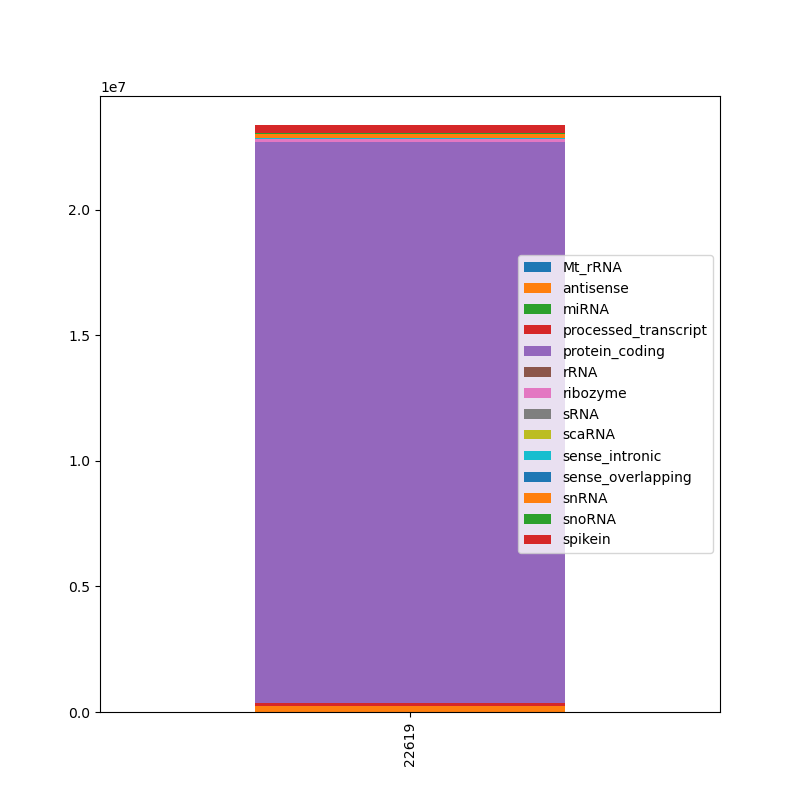
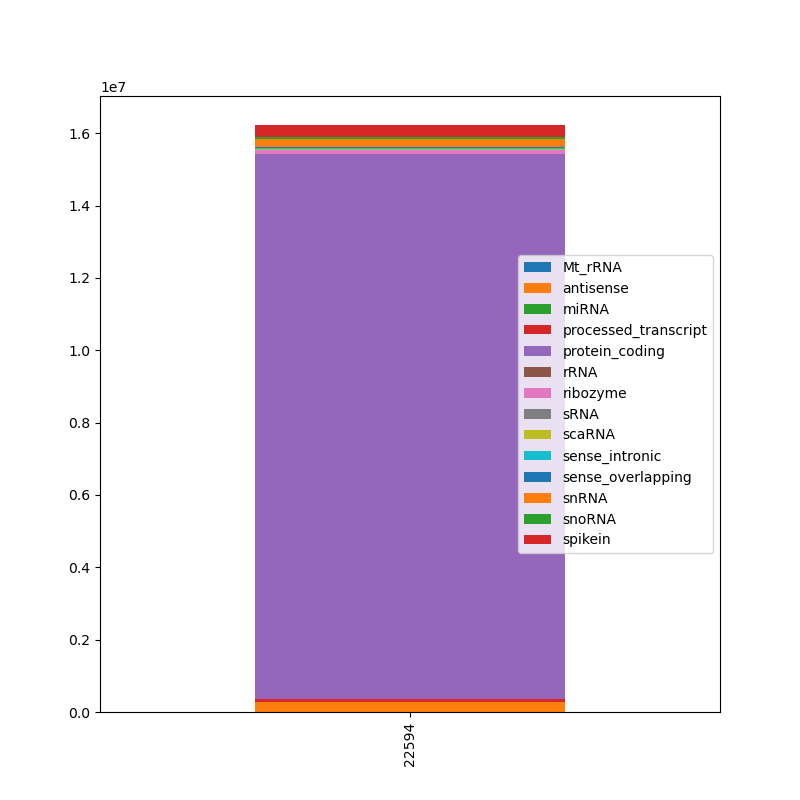
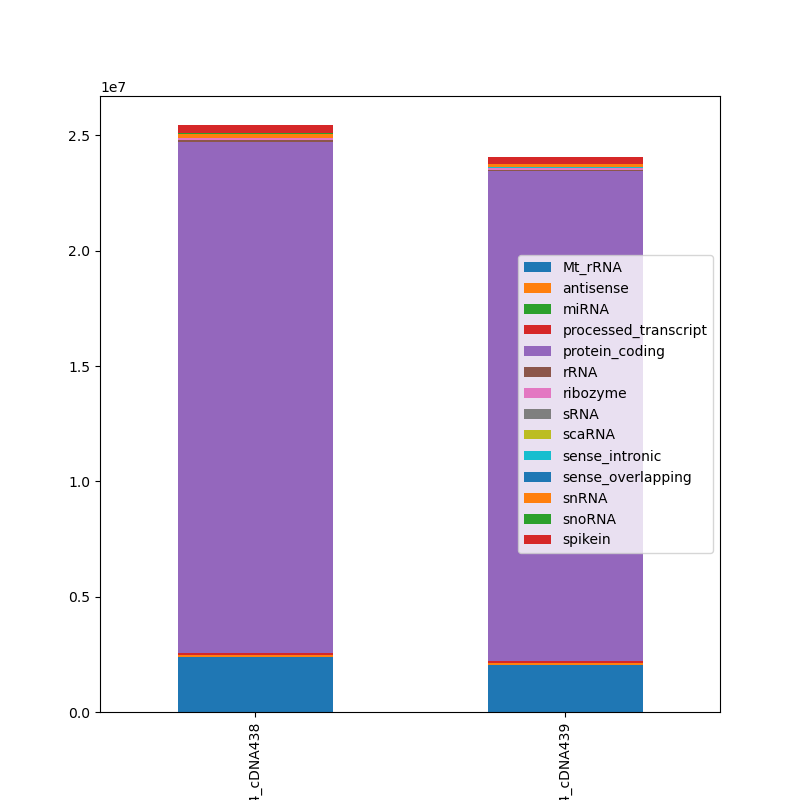
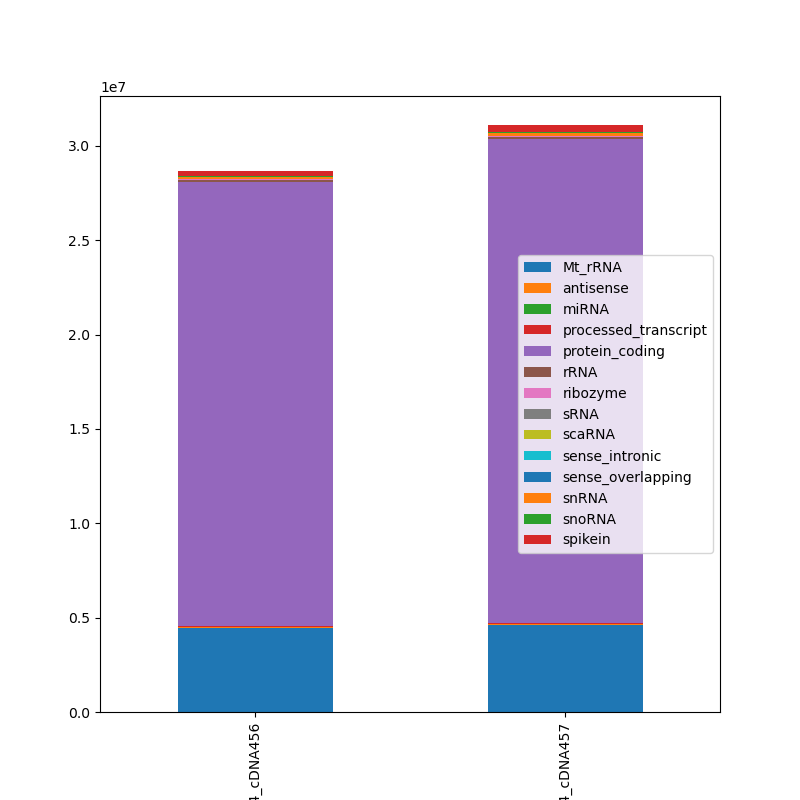
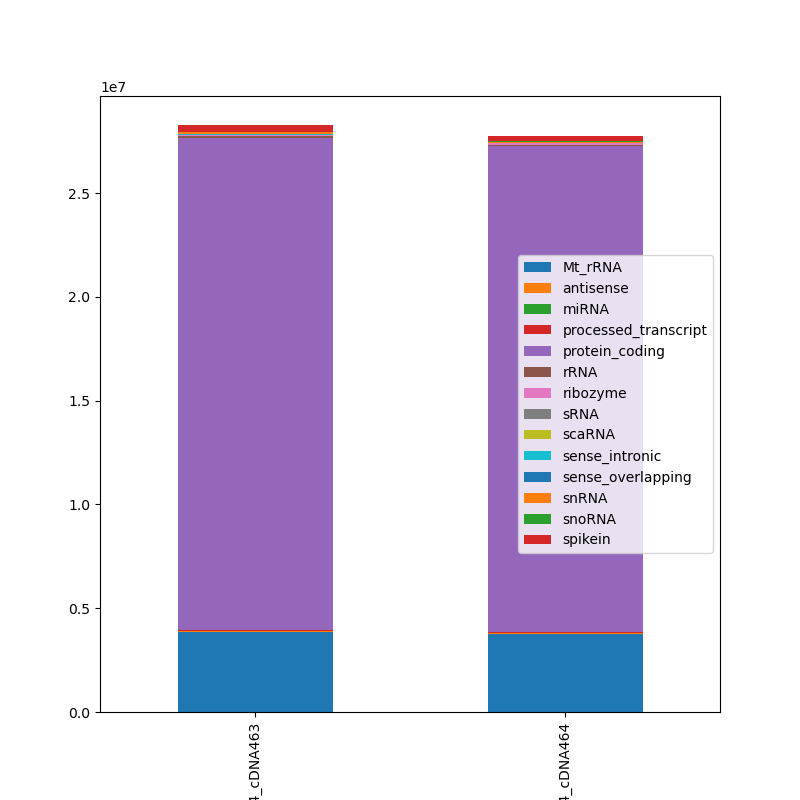
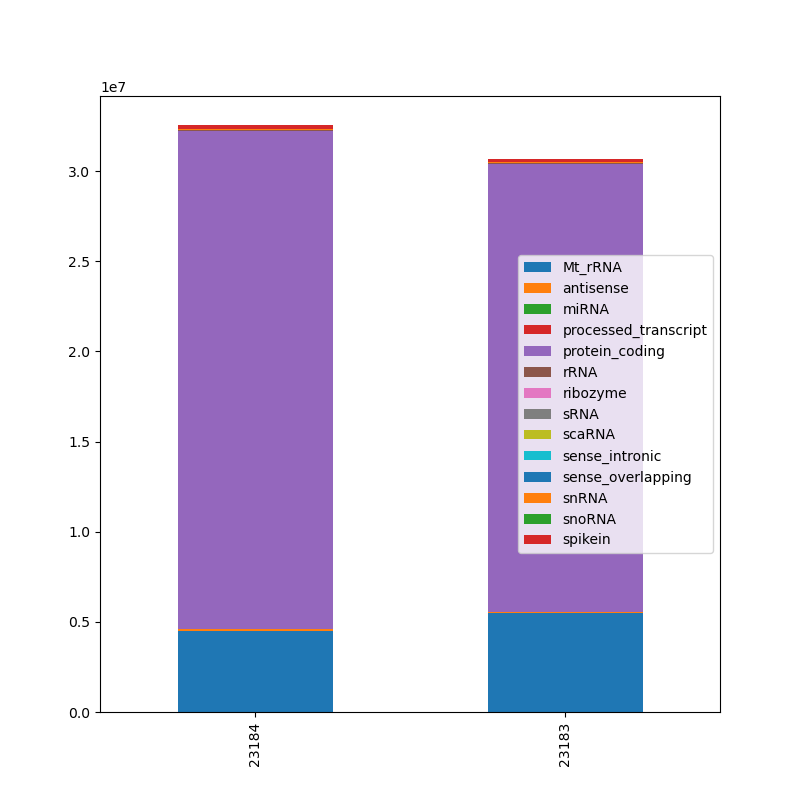
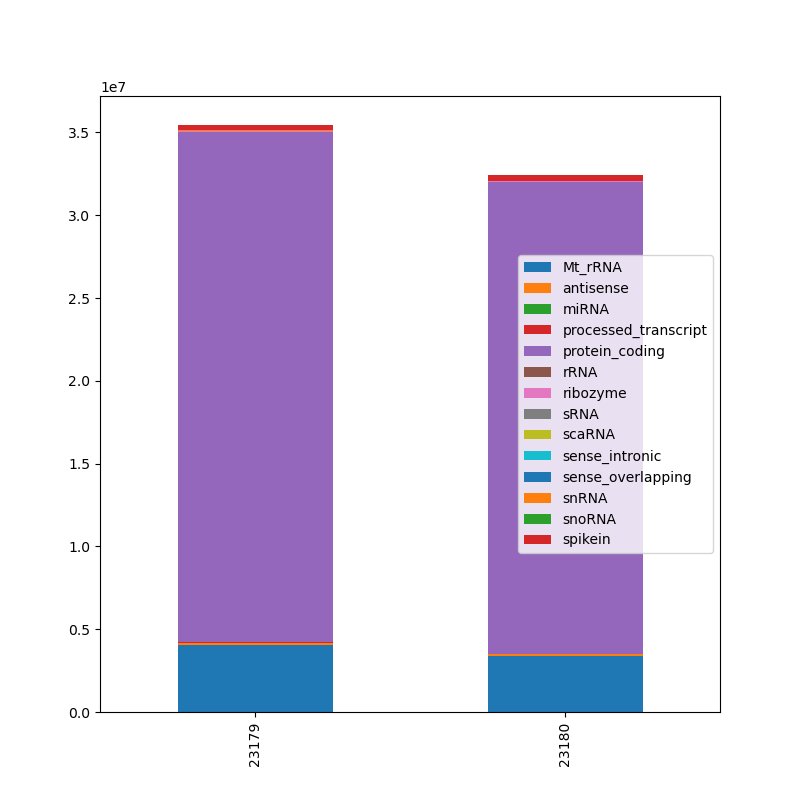
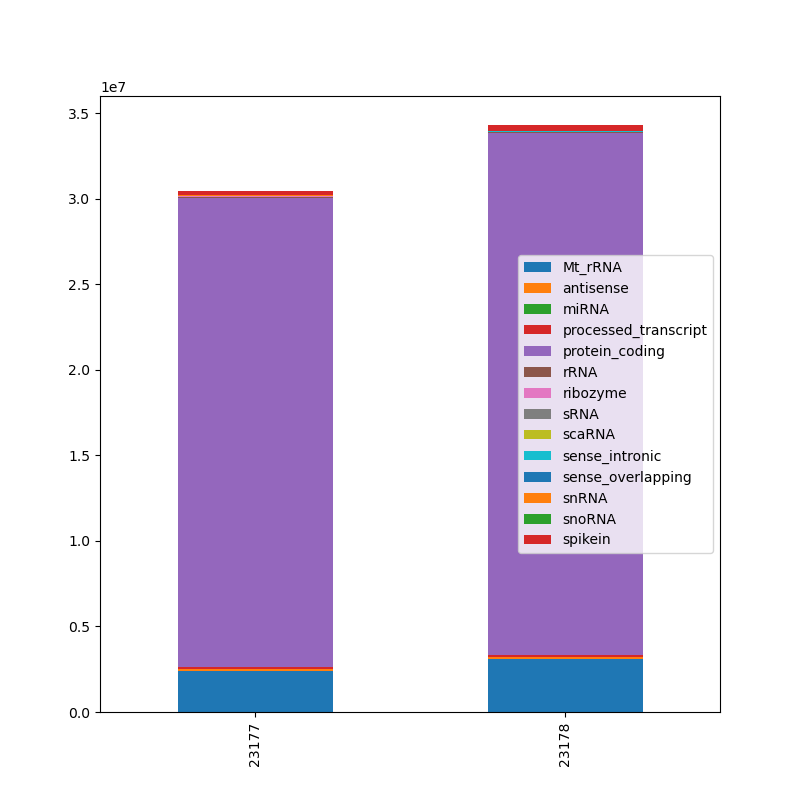
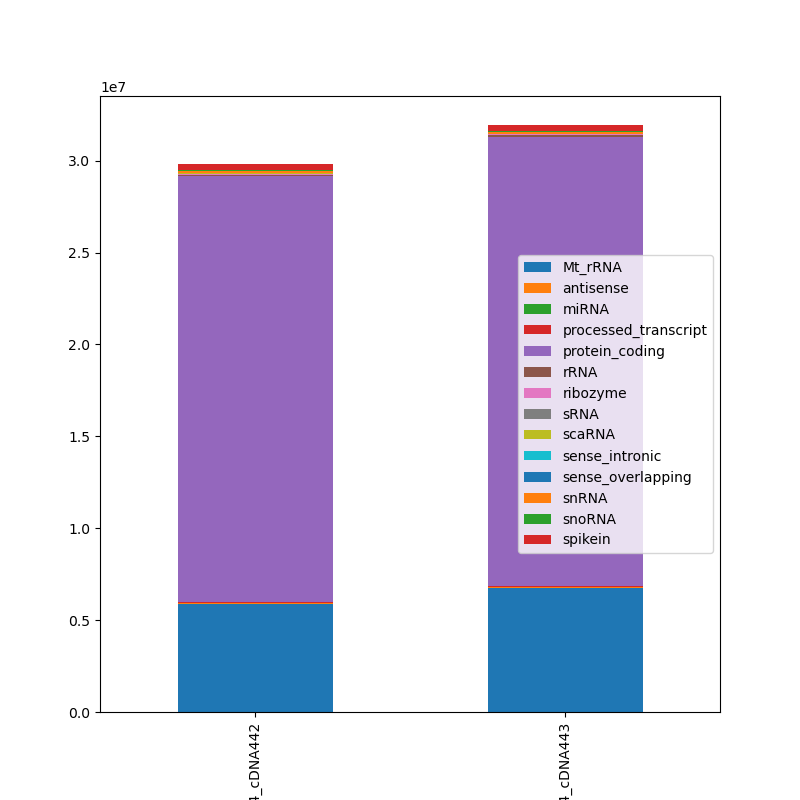
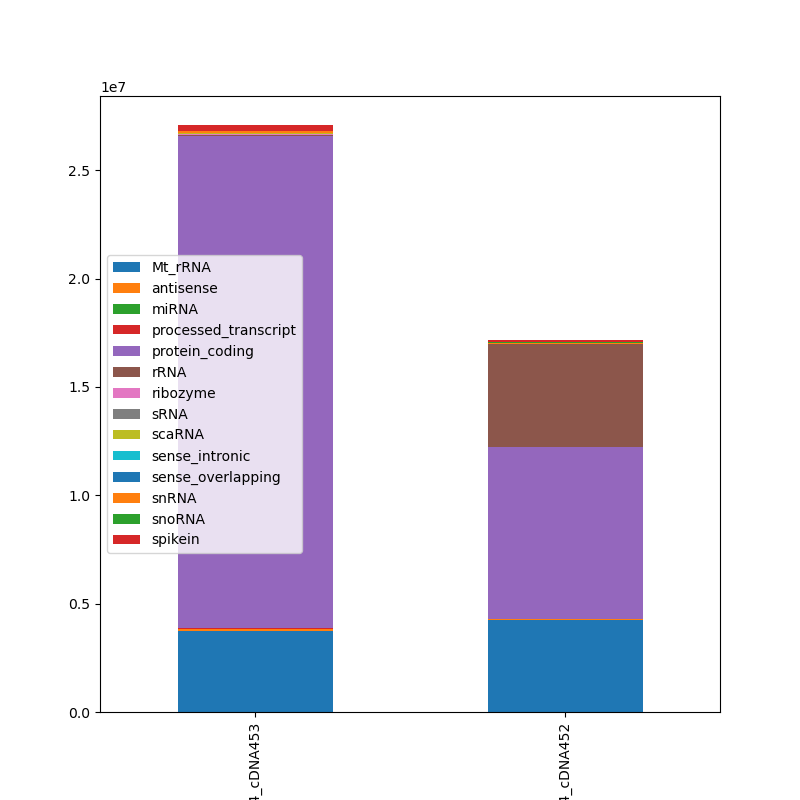
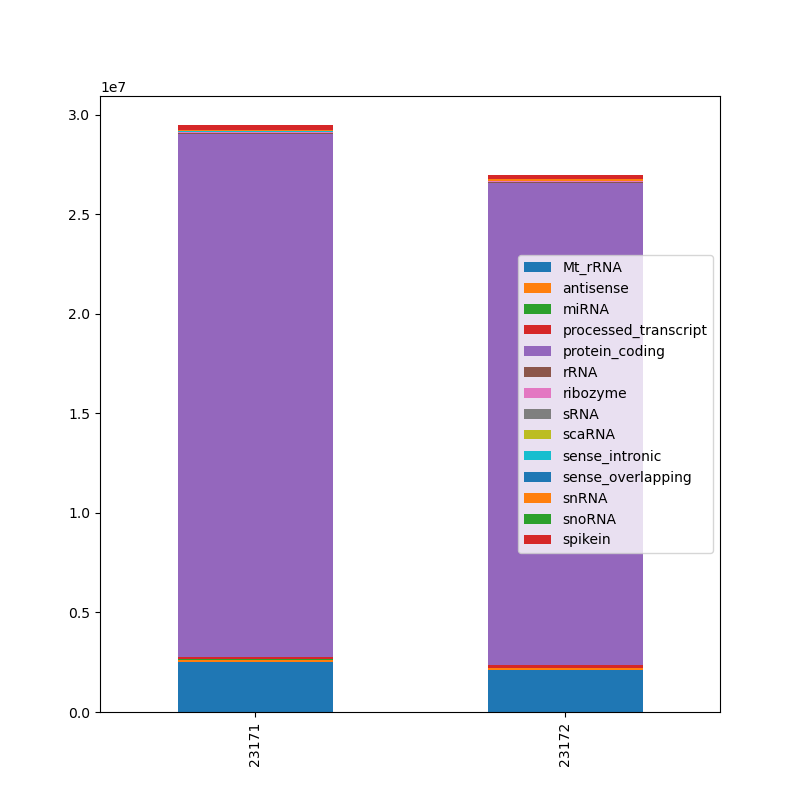
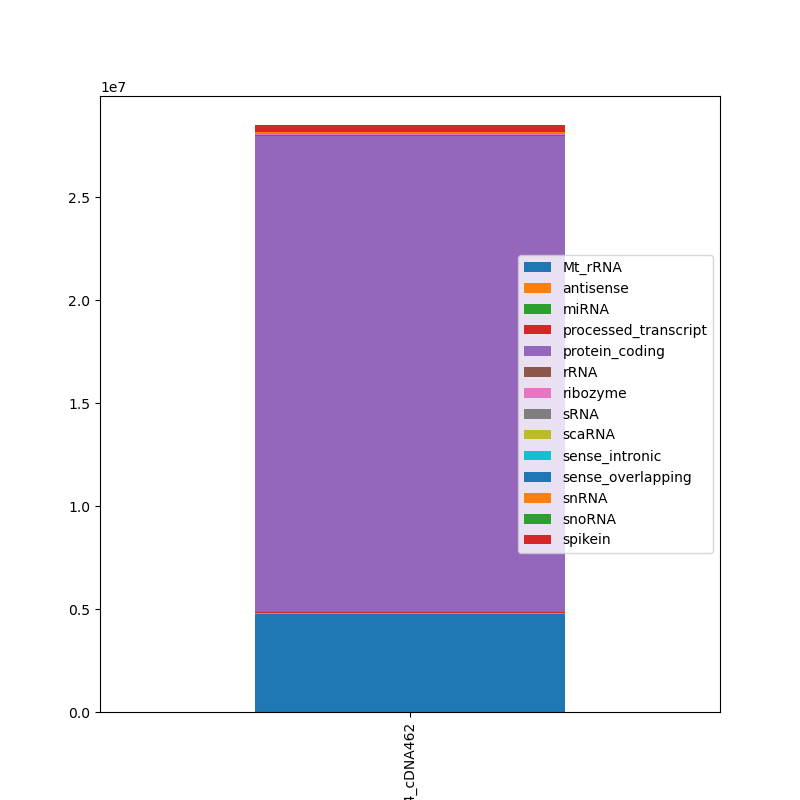
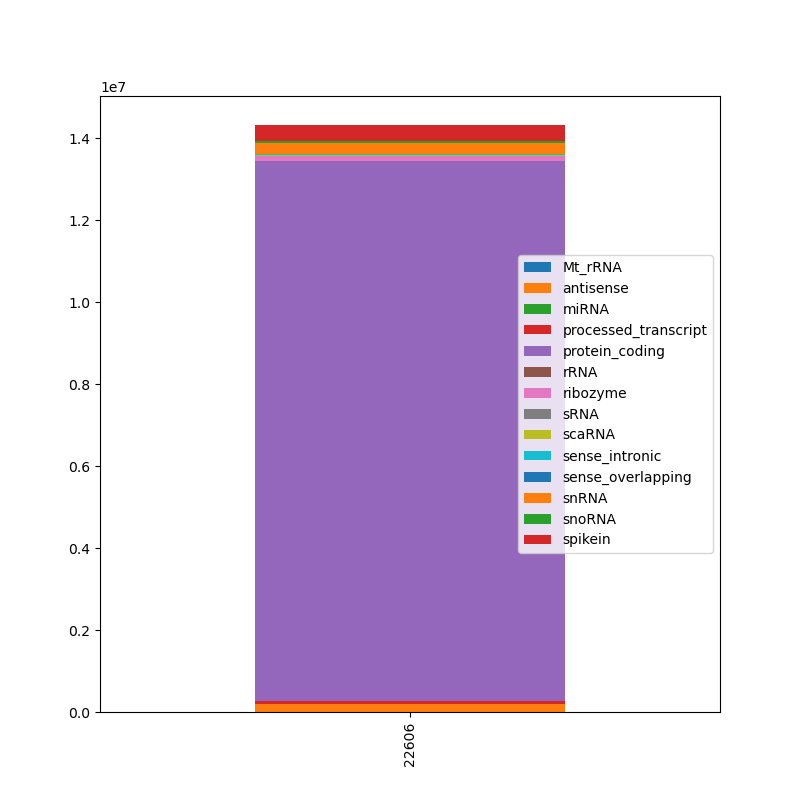
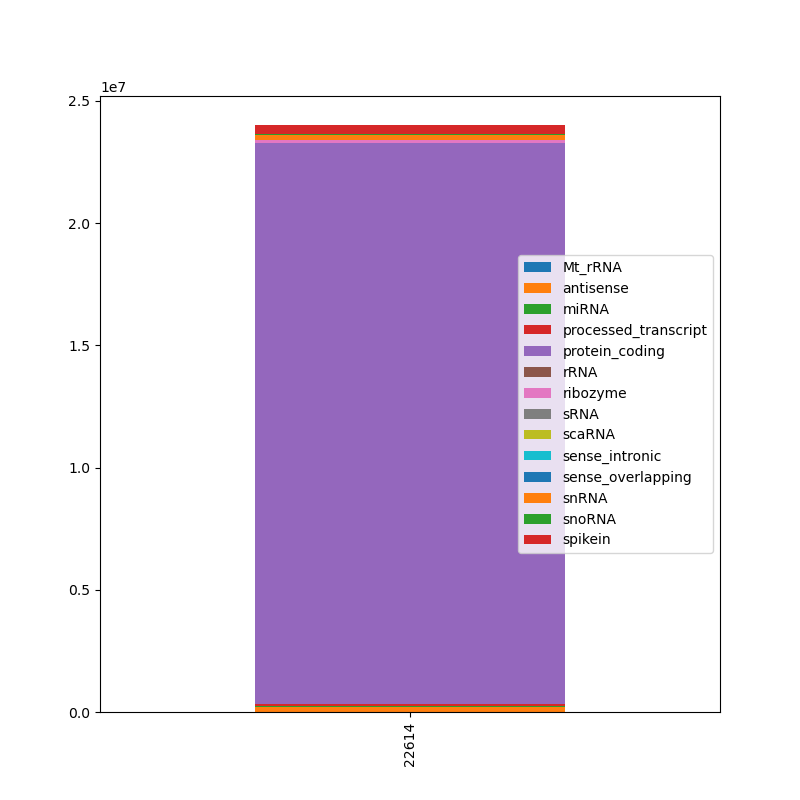
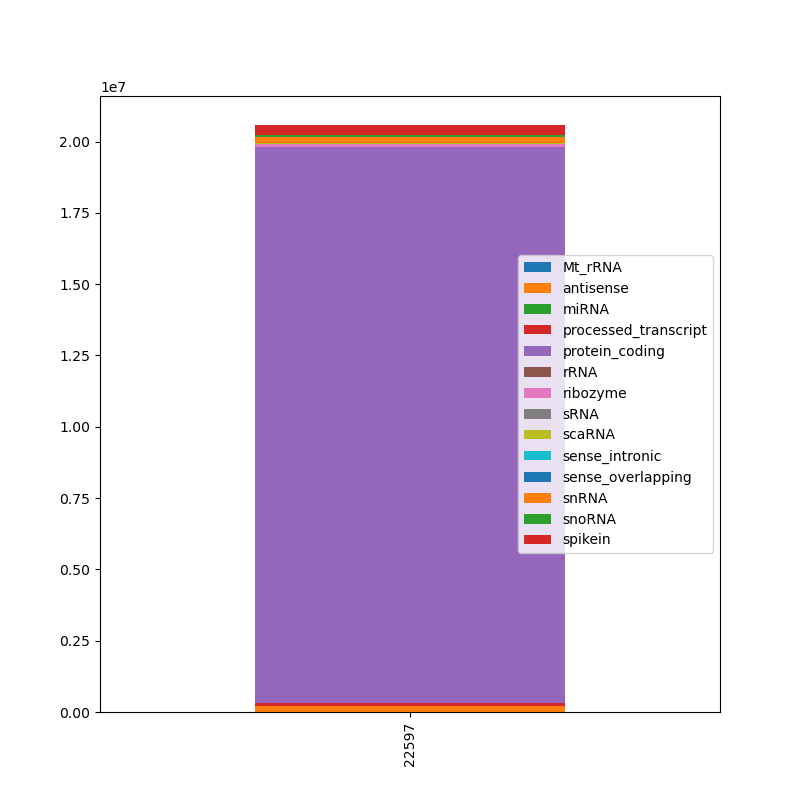
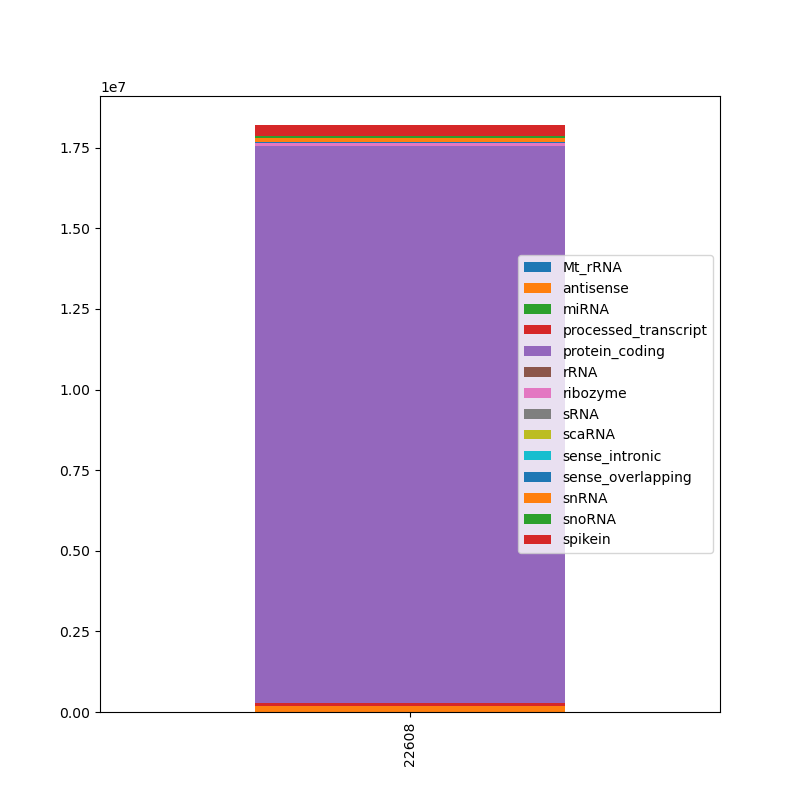
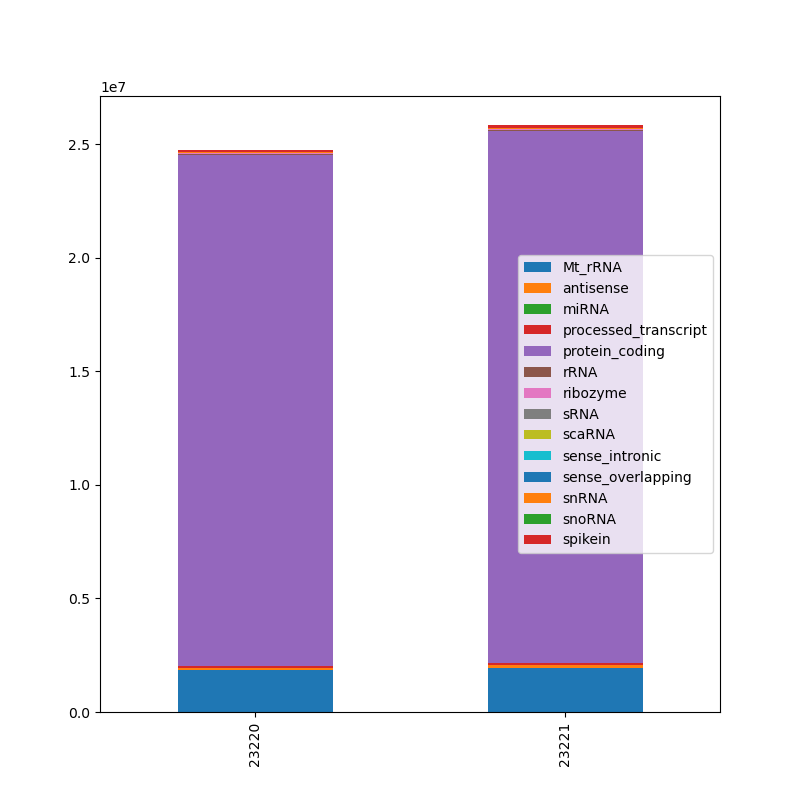
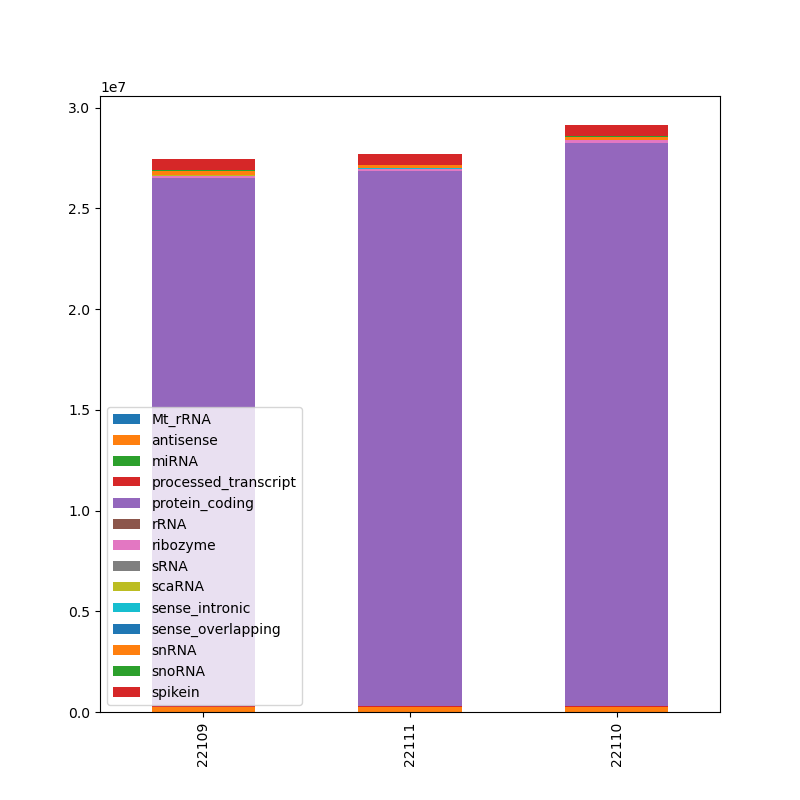
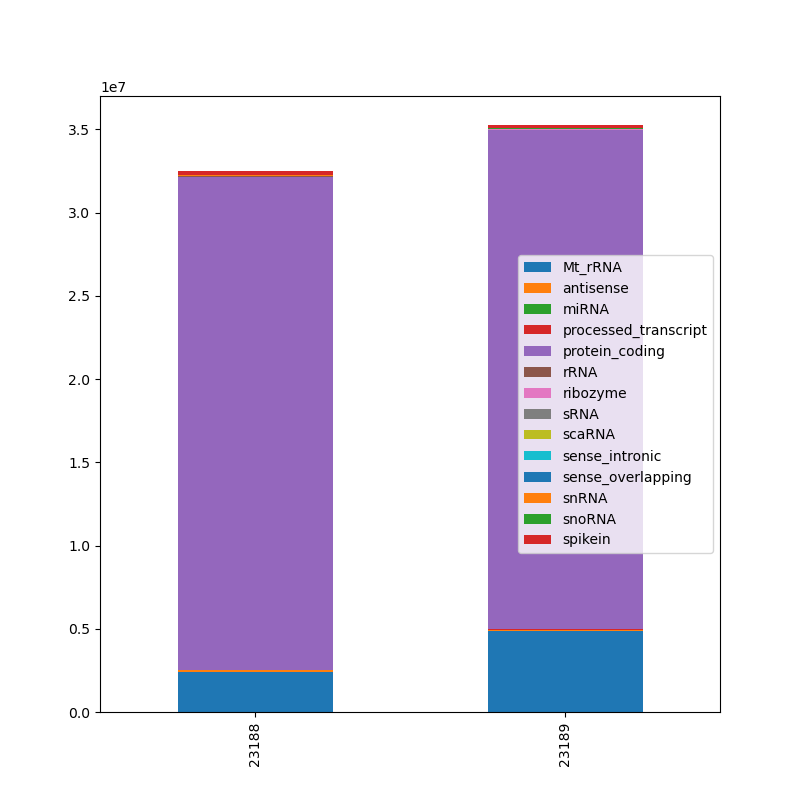
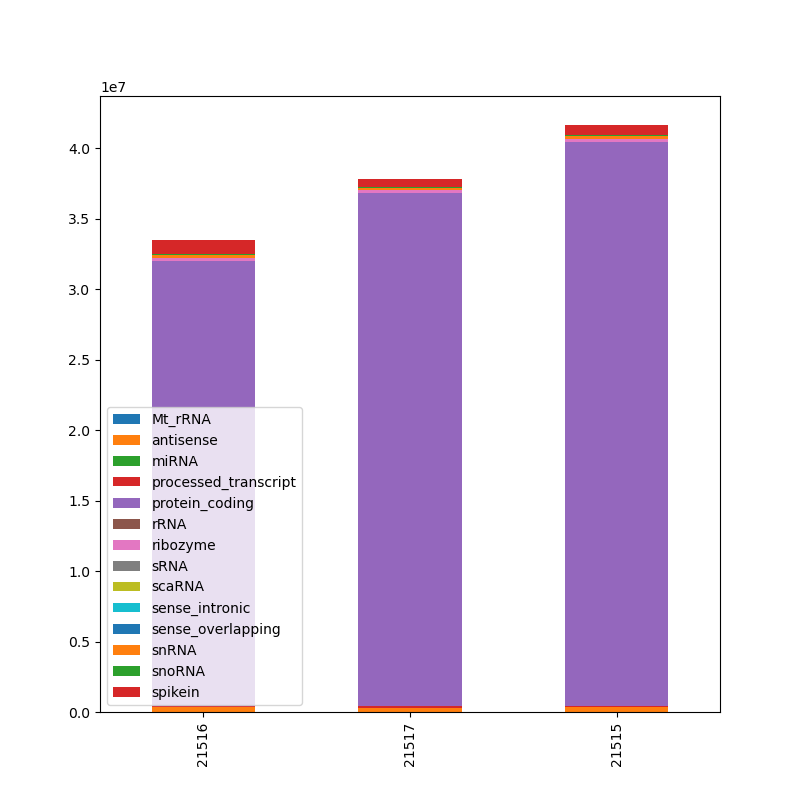
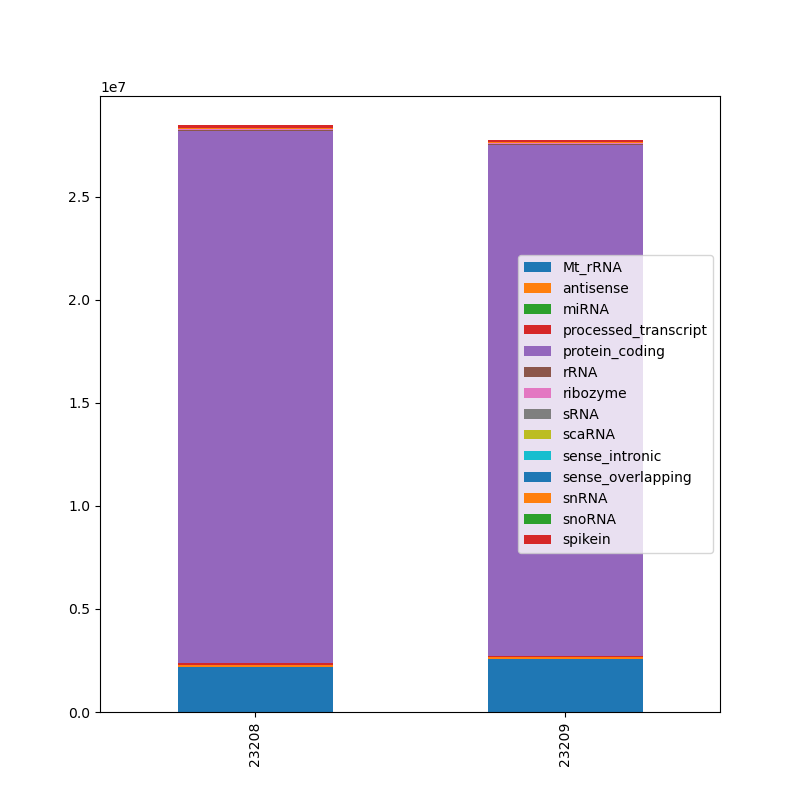
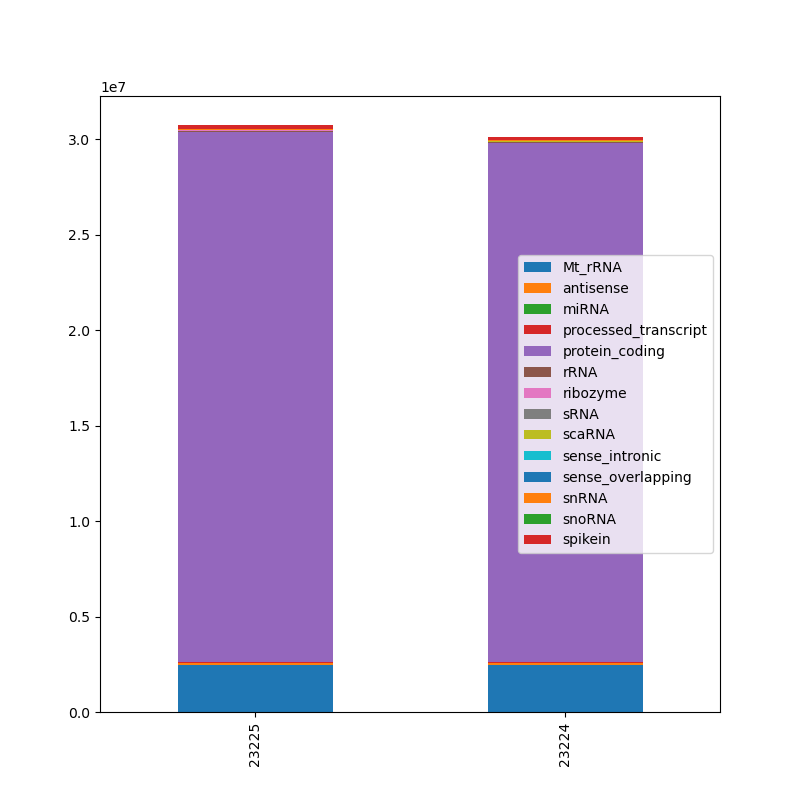
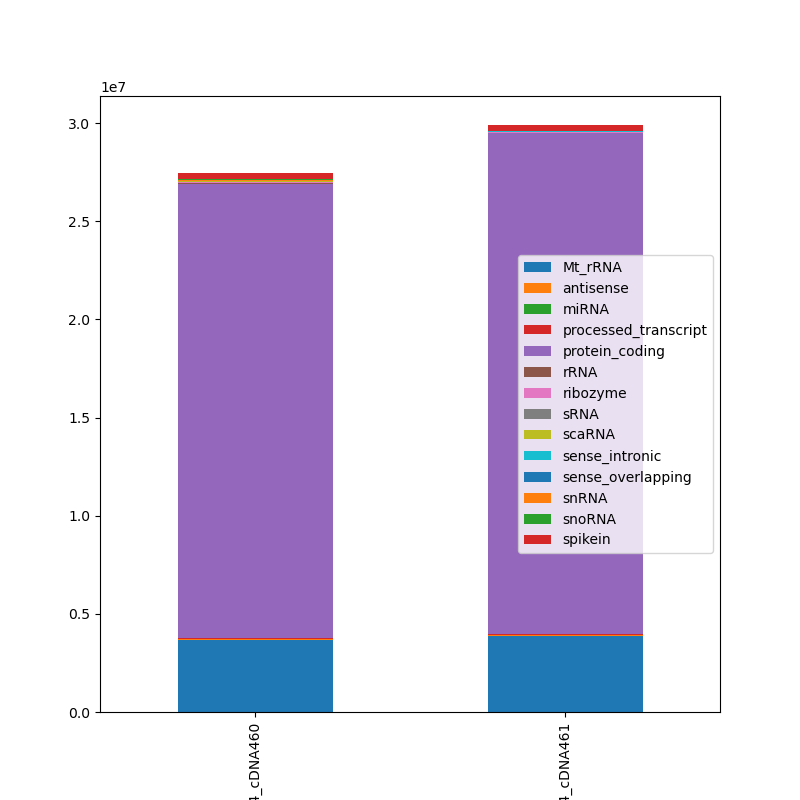
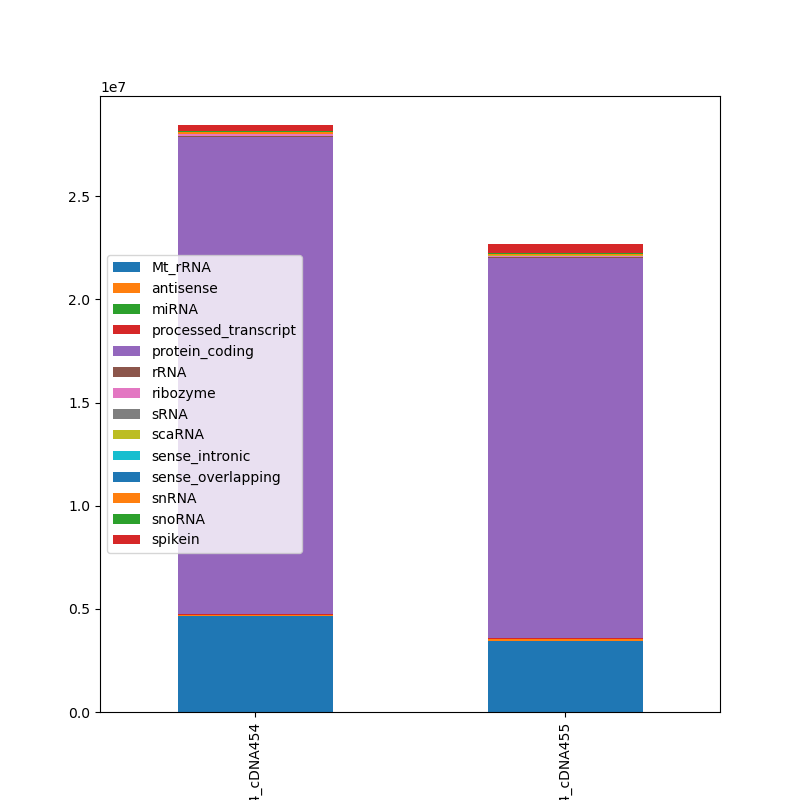
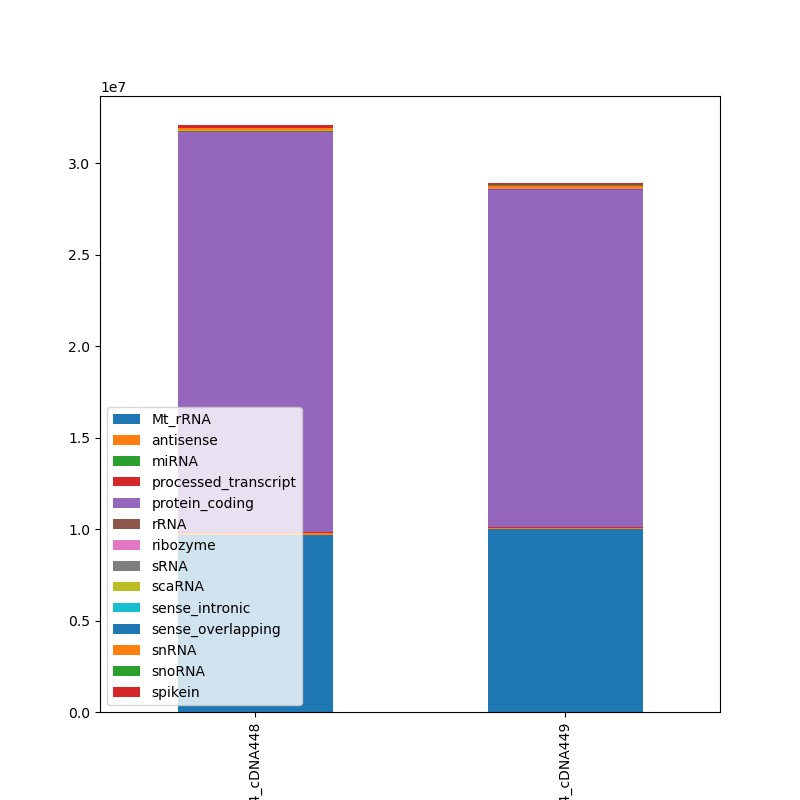
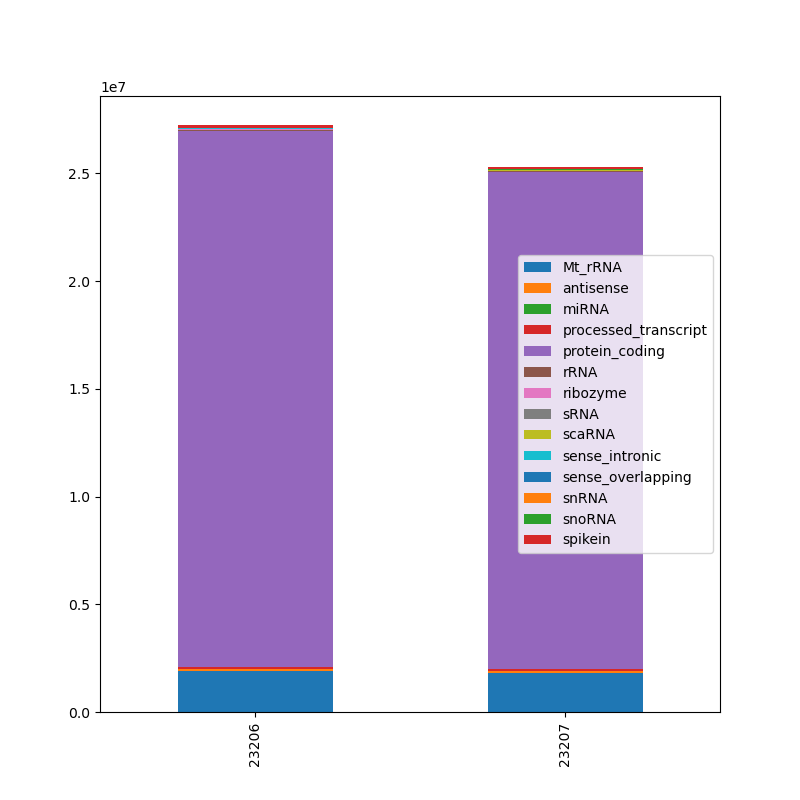
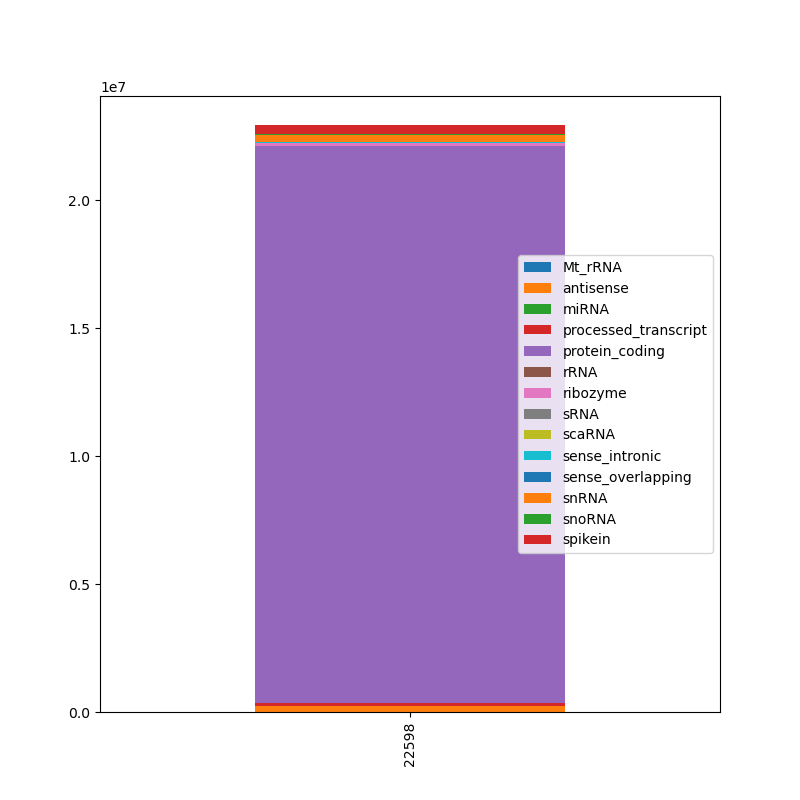
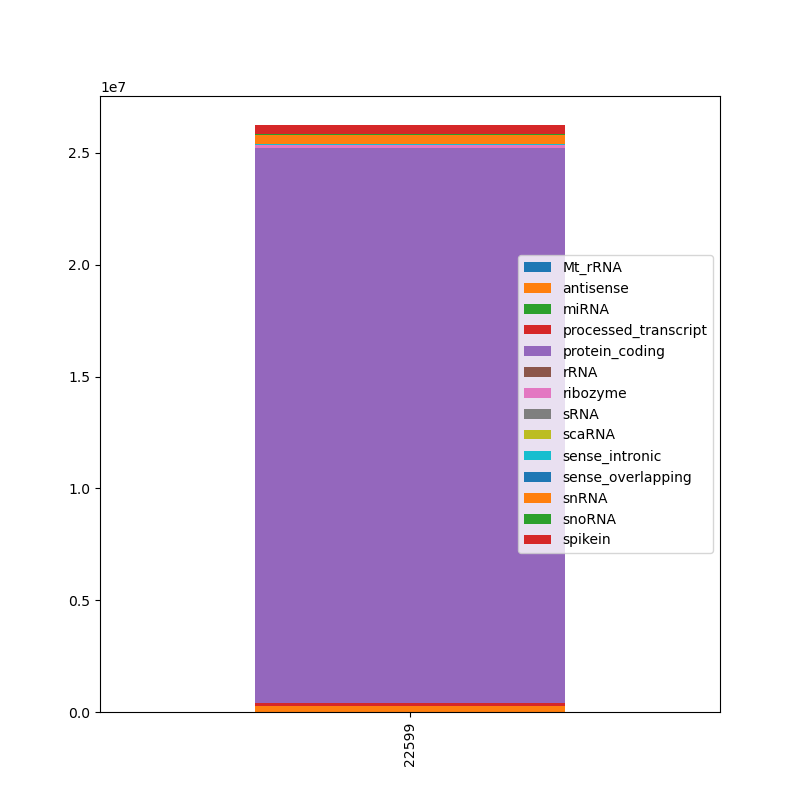
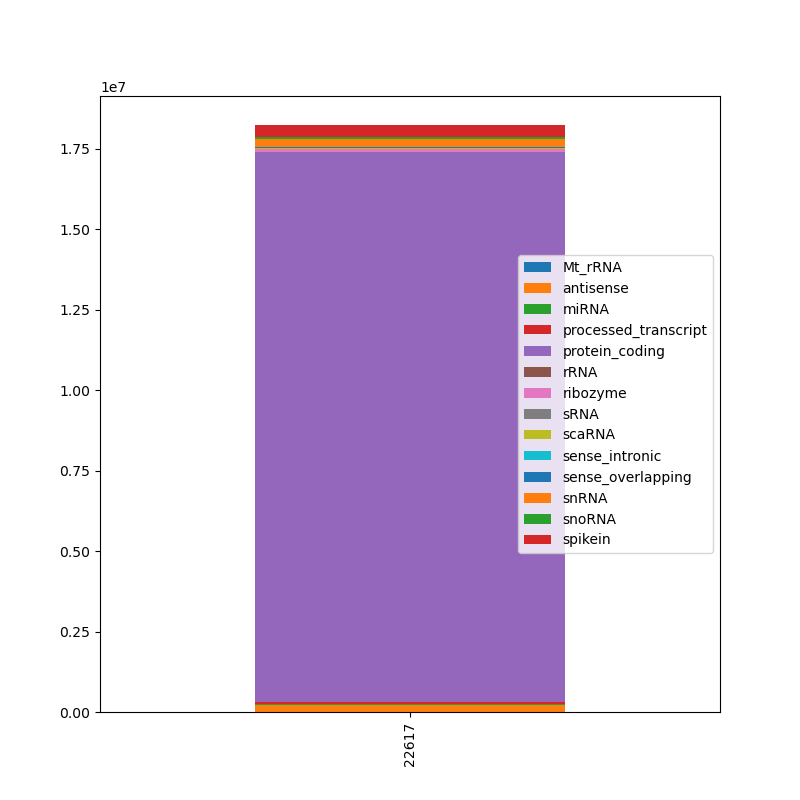
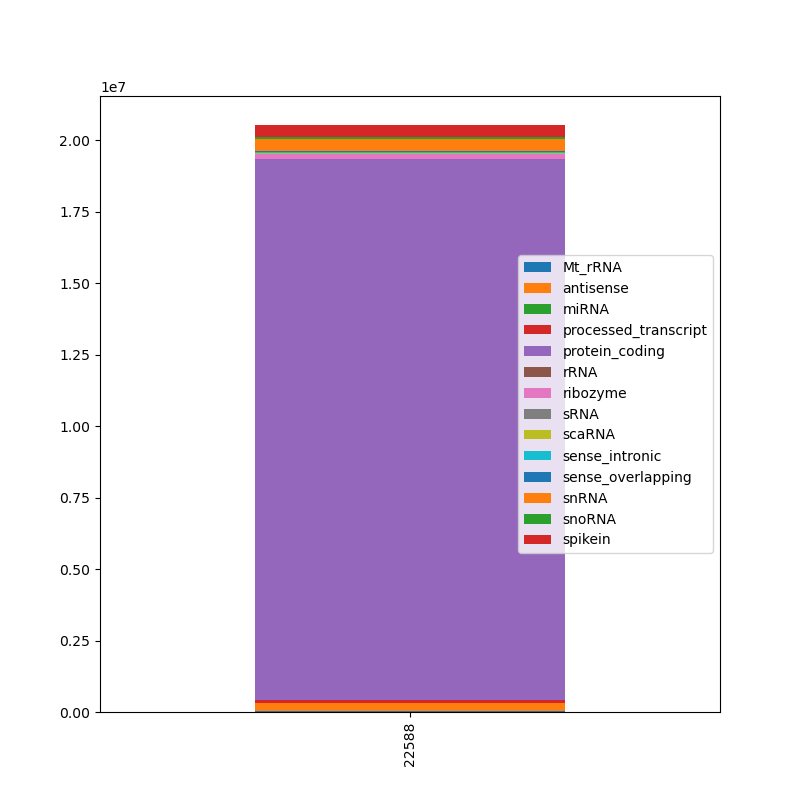
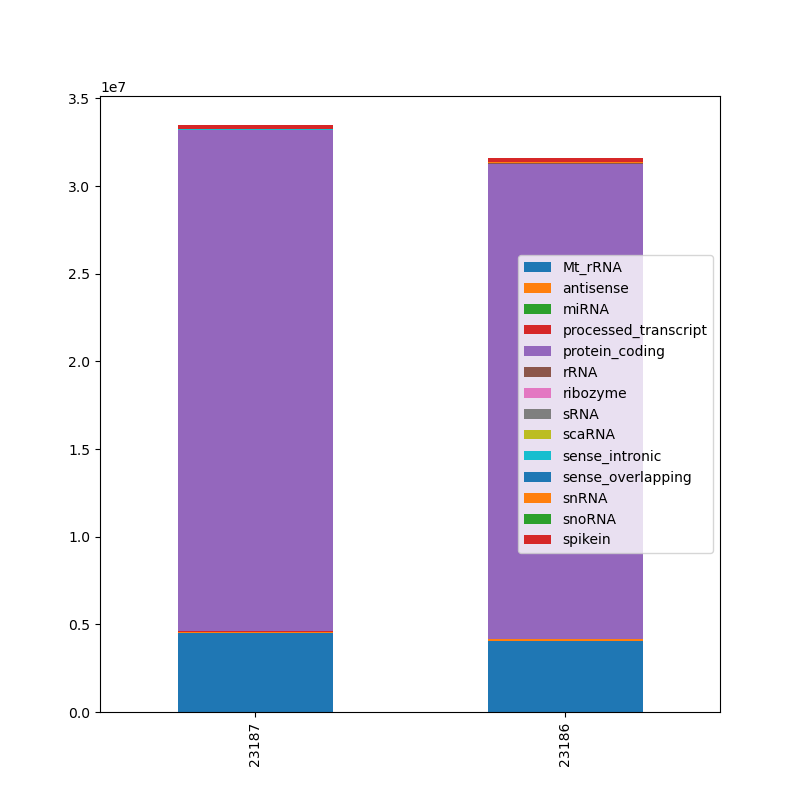
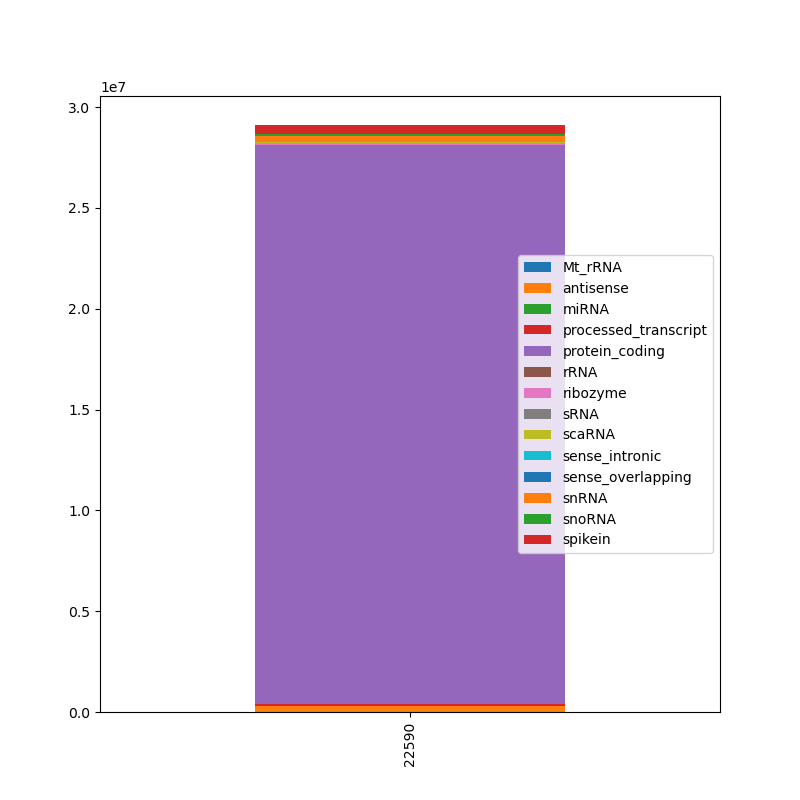
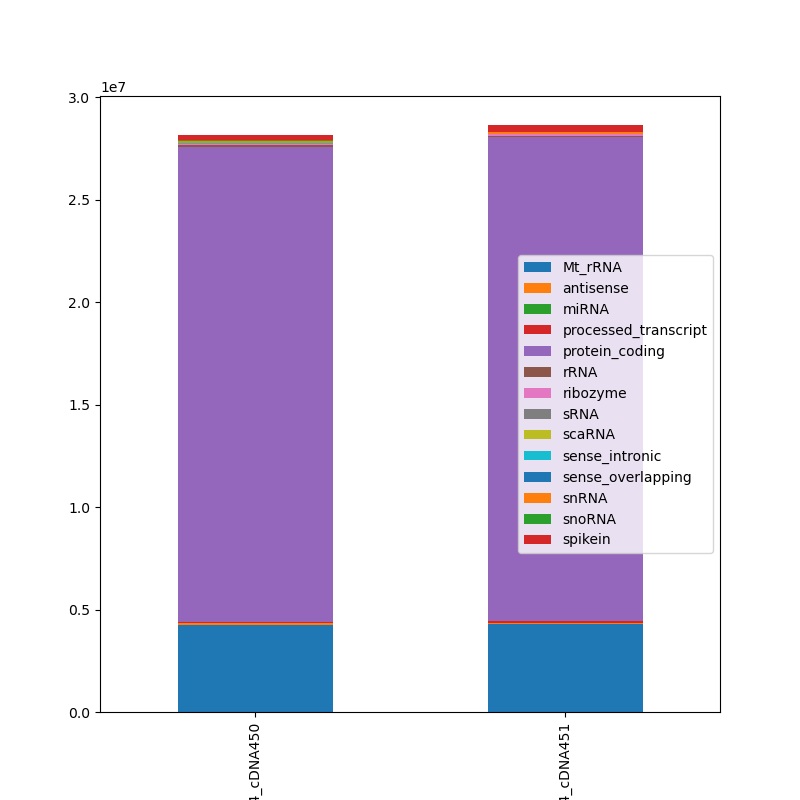
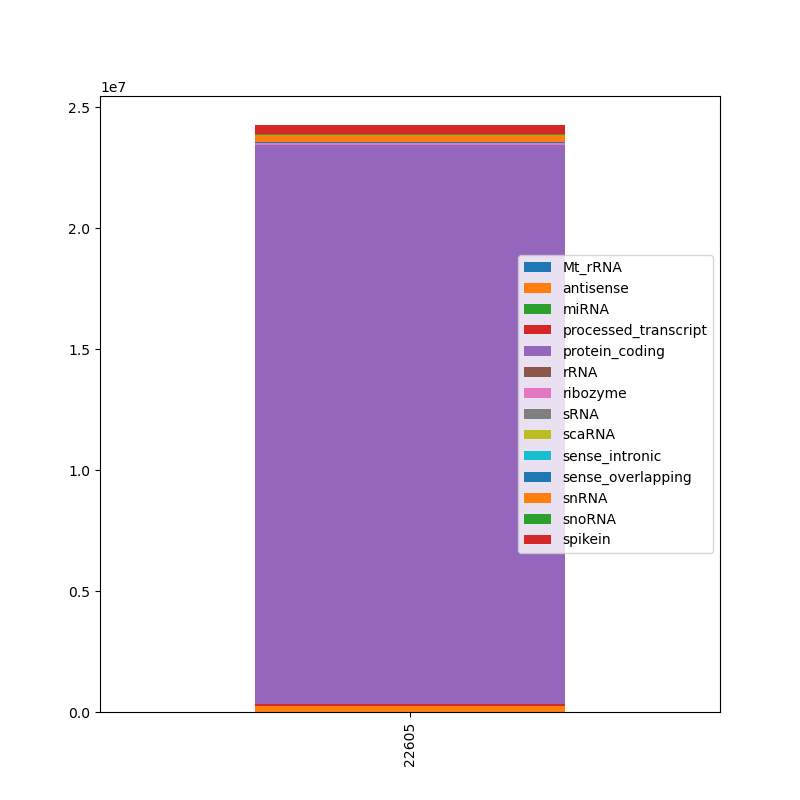

In [10]:
report = []
for row in graph["@graph"]:
    experiment = server.get_experiment(row["@id"])
    report.extend(report_experiment(experiment))
    
HTML("\n".join(report))